 Machine Learning (mL) Time Series Forecasting Model
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Loaded 57 data points from 57 input years
Data range: 1968 to 2024
Average Year-to-Year Change: 10.25%
Historical Volatility: 25.96%

Stationarity Analysis
Augmented Dickey-Fuller (ADF) Test:
--------------------------------------------------
ADF Statistic: 2.0290
p-value: 0.9987
Critical Values: {'1%': -3.552928203580539, '5%': -2.9147306250000002, '10%': -2.595137155612245}

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
--------------------------------------------------
KPSS Statistic: 1.0039
p-value: 0.0100
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree

 Model Selection & Evaluation
--------------------------------------------------
Testing Bayesian Structural Time Series (BSTS) Testing....
--------------------------------------------------
✓ BSTS Model 

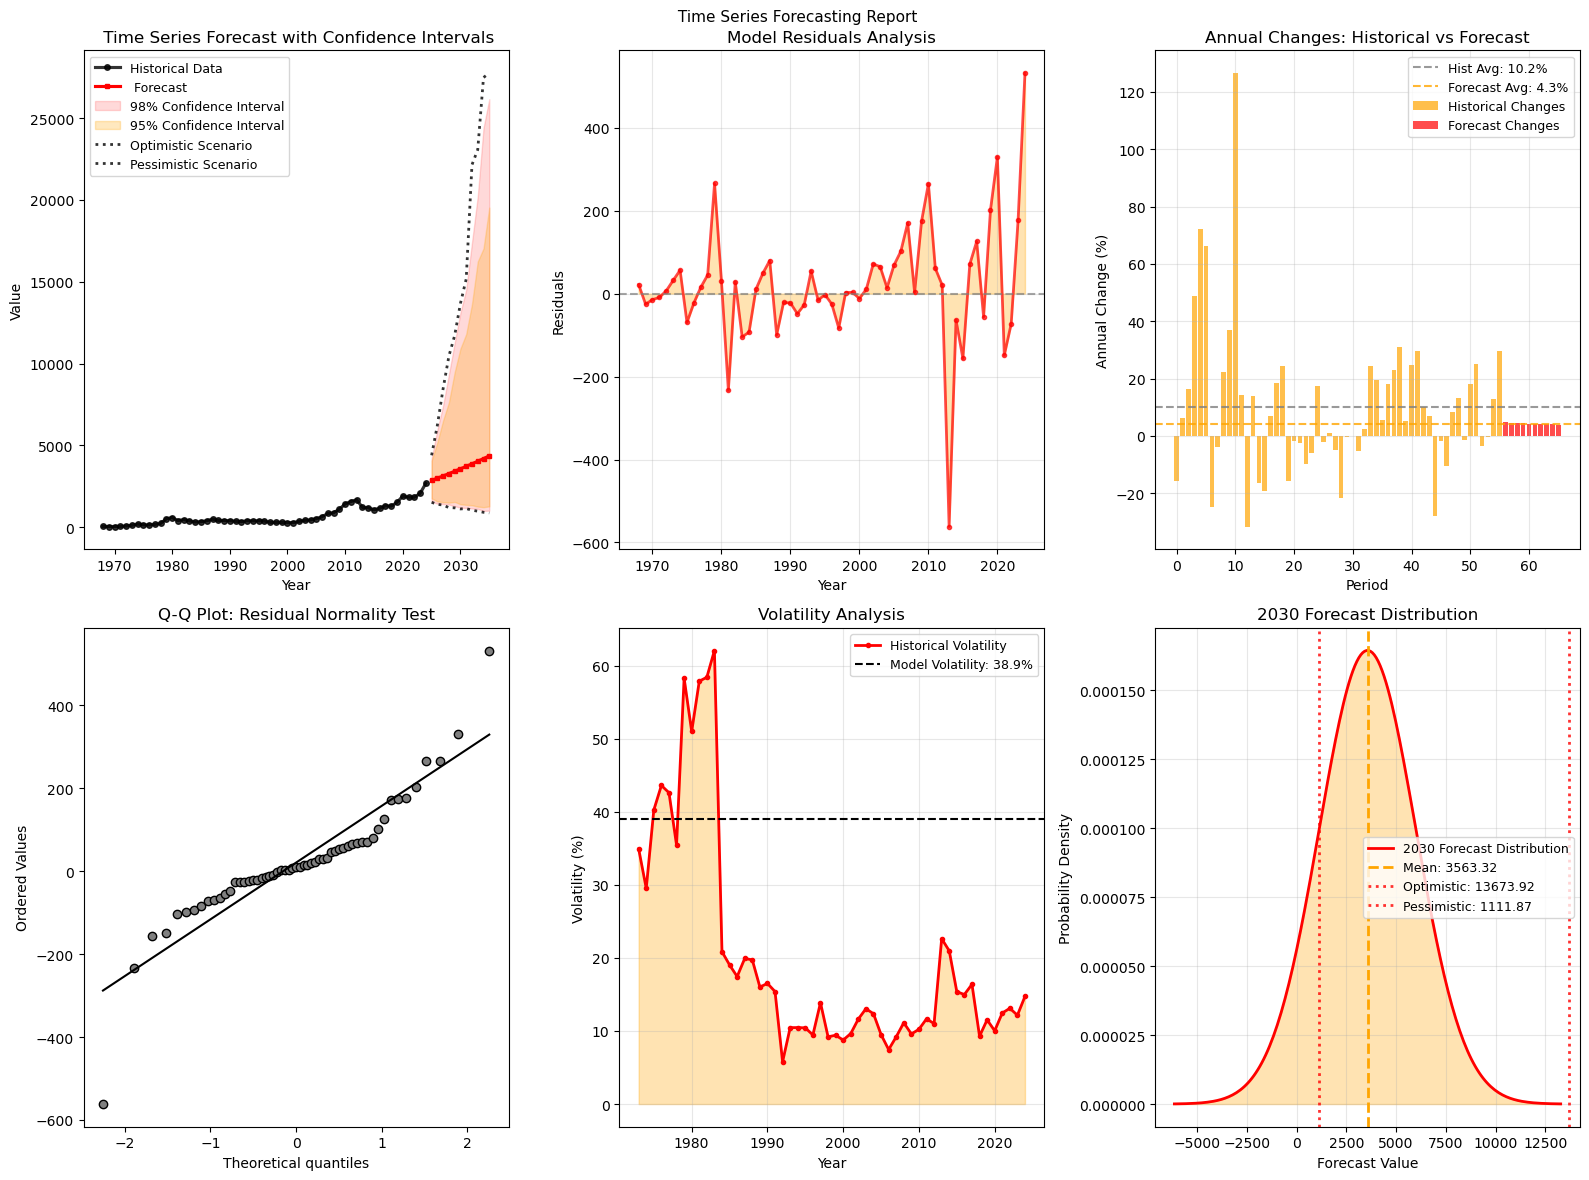

In [ ]:
#GOLD PRICE

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pmdarima as pm
warnings.filterwarnings('ignore')

class TimeSeriesForecast:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        self.residuals = None
        self.best_model_type = None
        self.volatility_model = None
        self.forecast_lower_95 = None
        self.forecast_upper_95 = None
        self.forecast_lower_98 = None
        self.forecast_upper_98 = None
        self.volatility = None
        self.forecast_high = None
        self.forecast_low = None
        self.historical_annual_changes = None
        
        print(" Machine Learning (mL) Time Series Forecasting Model")
        print("~"*100)
    
    def load_data(self, data_dict):
        # Handle missing years between 1960-2024 by filling missing years with 'Not a Number' (NaN)
        full_range = range(1960, 2025) 
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Convert to pandas series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Remove NaN values for modeling
        self.clean_data = self.data.dropna()
        
        # Calculate historical annual changes for forecast validation
        self.historical_annual_changes = self.clean_data.pct_change().dropna()
        
        # Volatility modeling
        self.returns = self.clean_data.pct_change().dropna()
        self.log_data = np.log(self.clean_data)
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        print(f"Average Year-to-Year Change: {self.returns.mean() * 100:.2f}%")
        print(f"Historical Volatility: {self.returns.std() * 100:.2f}%")

    def stationarity_tests(self):
        print("\nStationarity Analysis")
        print("="*50)
        
        # Augmented Dickey-Fuller (ADF) Test
        adf_result = adfuller(self.clean_data, autolag='AIC')
        print(f"Augmented Dickey-Fuller (ADF) Test:")
        print("-"*50)
        print(f"ADF Statistic: {adf_result[0]:.4f}")
        print(f"p-value: {adf_result[1]:.4f}")
        print(f"Critical Values: {adf_result[4]}") 
        
        # Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
        kpss_result = kpss(self.clean_data, regression='c')
        print(f"\nKwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")
        print("-"*50)
        print(f"KPSS Statistic: {kpss_result[0]:.4f}")
        print(f"p-value: {kpss_result[1]:.4f}")
        print(f"Critical Values: {kpss_result[3]}")
        
        adf_stationary = adf_result[1] <= 0.05
        kpss_stationary = kpss_result[1] > 0.05
        
        if adf_stationary and kpss_stationary:
            print("\n✓ ⚠ ✓ Series is Stationary | ADF & KPSS Agree")
            return True, 0
        elif not adf_stationary and not kpss_stationary:
            print("\n⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree")
            return False, 1
        else:
            print("\n⚠ ⚠ ⚠ ADF & KPSS Tests Disagree")
            return False, 1

    def model_selection(self):
        print("\n Model Selection & Evaluation")
        print("-"*50)
        
        models = {}
        
        # 1. Bayesian Structural Time Series (BSTS) - Using Unobserved Components
        try:
            print("Testing Bayesian Structural Time Series (BSTS) Testing....")
            print("-"*50)
            # BSTS using local linear trend with irregular component
            bsts_model = UnobservedComponents(
                self.clean_data,
                level='local linear trend',  # Trend component
                irregular=True,              # Irregular/noise component
                stochastic_level=True,       # Allow level to evolve
                stochastic_trend=True,       # Allow trend to evolve
                freq_seasonal=None           # No seasonal for annual data
            )
            
            bsts_fitted = bsts_model.fit(disp=False, maxiter=1000)
            models['BSTS'] = {'model': bsts_fitted, 'type': 'BSTS'}
            print(f"✓ BSTS Model fitted with AIC: {bsts_fitted.aic:.2f}")
            
        except Exception as e:
            print(f"⚠ BSTS model failed: {e}")

        # 2. State Space Model - Dynamic Linear Model with Kalman Filter
        try:
            print("Testing State Space Model (Dynamic Linear Model)....")
            print("-"*50)
            # Create a dynamic factor model as state space representation
            dlm_model = UnobservedComponents(
                self.clean_data,
                level='local level',     # Random walk level
                trend=True,              # Include trend
                irregular=True,          # Include irregular component
                stochastic_level=True,   # Stochastic level evolution
                stochastic_irregular=False
            )
            
            dlm_fitted = dlm_model.fit(disp=False, maxiter=1000)
            models['STATE_SPACE'] = {'model': dlm_fitted, 'type': 'STATE_SPACE'}
            print(f"✓ State Space Model fitted with AIC: {dlm_fitted.aic:.2f}")
            
        except Exception as e:
            print(f" State Space model failed: {e}")

        # 3. ARIMA with better parameter search
        try:
            print(" AutoRegressive Integrated Moving Average (ARIMA)....")
            print("-"*50)
            best_arima = pm.auto_arima(
                self.clean_data, 
                start_p=0, start_q=0, max_p=4, max_q=4, max_d=2,
                seasonal=False, stepwise=False, suppress_warnings=True, 
                error_action='ignore', information_criterion='aic',
                n_jobs=-1, with_intercept=True
            )

            if best_arima:
                models['ARIMA'] = {'model': best_arima, 'type': 'ARIMA'}
                print(f"✓ ARIMA{best_arima.order} model with AIC: {best_arima.aic():.2f}")

        except Exception as e:
            print(f"ARIMA model failed: {e}")

        # 4. SARIMA
        try:
            print(" Seasonal ARIMA (SARIMA)...")
            print("-"*50)
            best_sarima = pm.auto_arima(
                self.clean_data, seasonal=True, m=3, start_p=0, start_q=0, 
                max_p=3, max_q=3, start_P=0, start_Q=0, max_P=2, max_Q=2, 
                max_d=2, max_D=1, trace=False, error_action='ignore', 
                suppress_warnings=True, stepwise=False, n_jobs=-1,
                information_criterion='aic', with_intercept=True
            )

            if best_sarima:
                models['SARIMA'] = {'model': best_sarima, 'type': 'SARIMA'}
                print(f"✓ SARIMA model with AIC: {best_sarima.aic():.2f}")

        except Exception as e:
            print(f"SARIMA model failed: {e}")

        # 5. Exponential Smoothing
        try:
            print("Exponential Smoothing...")
            exp_model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None,
                initialization_method='estimated'
            )
            exp_fitted = exp_model.fit(optimized=True, use_brute=True)
            models['Exp_Smoothing'] = {'model': exp_fitted, 'type': 'Exp_Smoothing'}
            print(f"✓ Exponential Smoothing AIC: {exp_fitted.aic:.2f}")
            
        except Exception as e:
            print(f"Exponential Smoothing failed: {e}")

        # Select best model
        best_model = self._select_best_model(models)
        self.model = best_model['model']
        self.best_model_type = best_model['type']
        
        print(f"\n Selected Model: {self.best_model_type}")
        
        #  model info display
        try:
            if hasattr(self.model, 'aic'):
                aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
                print(f" Model AIC: {aic_value:.2f}")
            
            # Display model-specific information
            if self.best_model_type == 'BSTS':
                print(" BSTS advantages: Probabilistic, handles volatility, economic interpretation")
            elif self.best_model_type == 'STATE_SPACE':
                print(" State Space advantages: Flexible, handles non-linearity, trend-cycle decomposition")
                
        except Exception as e:
            print(f"Model info display error: {e}")

    def _select_best_model(self, models):
        if not models:
            raise ValueError("No valid models found")

        def get_aic(model_info):
            try:
                aic = getattr(model_info['model'], 'aic', np.inf)
                return aic() if callable(aic) else aic
            except:
                return np.inf

        # Prioritize BSTS and State Space models for economic data
        model_priority = {'BSTS': 0.95, 'STATE_SPACE': 0.97, 'ARIMA': 1.0, 'SARIMA': 1.0, 'Exp_Smoothing': 1.02}
        
        best_model = None
        best_adjusted_aic = np.inf
        
        for model_type, model_info in models.items():
            aic = get_aic(model_info)
            priority_factor = model_priority.get(model_type, 1.0)
            adjusted_aic = aic * priority_factor
            
            if adjusted_aic < best_adjusted_aic:
                best_adjusted_aic = adjusted_aic
                best_model = model_info
                
        return best_model

    def estimate_volatility(self):
        # volatility estimation with better residual handling
        residuals = None
        
        try:
            if self.best_model_type in ['BSTS', 'STATE_SPACE']:
                # For state space models, use standardized residuals
                residuals = self.model.resid_pearson if hasattr(self.model, 'resid_pearson') else self.model.resid
            elif hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals = self.model.resid_
            else:
                # For pmdarima models
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
        except:
            residuals = self.returns

        # volatility with regime-aware estimation
        if isinstance(residuals, pd.Series):
            recent_residuals = residuals.iloc[-min(10, len(residuals)):]
            volatility = recent_residuals.std()
        else:
            volatility = np.std(residuals) if len(residuals) > 0 else self.returns.std()
            
        # Ensure volatility is reasonable compared to historical data
        historical_vol = self.returns.std()
        if volatility > 3 * historical_vol:  # Cap extreme volatility
            volatility = 1.5 * historical_vol
        elif volatility < 0.1 * historical_vol:  # Floor too low volatility
            volatility = 0.5 * historical_vol
            
        return volatility

    def forecast_with_enhanced_reliability(self, years_ahead=11, n_simulations=1000):
        """ forecasting with historical pattern matching for reliability"""
        if self.model is None:
            raise ValueError("Model Not Fitted")
        
        print(f"\n Forecasts with {self.best_model_type}...")
        
        # 1. Generate base forecast
        if self.best_model_type in ['BSTS', 'STATE_SPACE']:
            # State space models use get_forecast
            forecast_obj = self.model.get_forecast(steps=years_ahead)
            base_forecast = forecast_obj.predicted_mean
            forecast_conf_int = forecast_obj.conf_int()
            forecast_std = forecast_obj.se_mean
            
        elif self.best_model_type == 'Exp_Smoothing':
            base_forecast = self.model.forecast(steps=years_ahead)
            forecast_std = np.std(self.model.resid) * np.sqrt(np.arange(1, years_ahead + 1))
            
        elif self.best_model_type in ['ARIMA', 'SARIMA']:
            base_forecast, forecast_conf_int = self.model.predict(n_periods=years_ahead, return_conf_int=True)
            forecast_std = (forecast_conf_int[:, 1] - forecast_conf_int[:, 0]) / (2 * 1.96)
            
        # 2.  forecast reliability using historical patterns
        enhanced_forecast = self._enhance_forecast_reliability(base_forecast, years_ahead)
        
        # 3. Generate realistic confidence intervals using Monte Carlo
        volatility = self.estimate_volatility()
        
        # 4. Monte Carlo simulation with historical pattern constraints
        simulations = self._monte_carlo_with_constraints(
            enhanced_forecast, volatility, forecast_std, years_ahead, n_simulations
        )
        
        # 5. Calculate confidence intervals
        lower_ci_95 = np.percentile(simulations, 2.5, axis=0)
        upper_ci_95 = np.percentile(simulations, 97.5, axis=0)
        lower_ci_98 = np.percentile(simulations, 1.0, axis=0)
        upper_ci_98 = np.percentile(simulations, 99.0, axis=0)
        
        high_extreme = np.percentile(simulations, 99.5, axis=0)
        low_extreme = np.percentile(simulations, 0.5, axis=0)
        
        # 6. Build forecast index
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 1, last_year + 1 + years_ahead)
        dates = pd.to_datetime([f"{year}-01-01" for year in forecast_years])
        
        # 7. Store results
        self.forecast = pd.Series(enhanced_forecast, index=dates)
        self.forecast_lower_95 = pd.Series(lower_ci_95, index=dates)
        self.forecast_upper_95 = pd.Series(upper_ci_95, index=dates)
        self.forecast_lower_98 = pd.Series(lower_ci_98, index=dates)
        self.forecast_upper_98 = pd.Series(upper_ci_98, index=dates)
        self.forecast_high = pd.Series(high_extreme, index=dates)
        self.forecast_low = pd.Series(low_extreme, index=dates)
        self.volatility = volatility
        
        # 8. Validate forecast reliability
        self._validate_forecast_patterns()
        
        return self.forecast

    def _enhance_forecast_reliability(self, base_forecast, years_ahead):        
        # Calculate historical statistics
        hist_mean_change = self.historical_annual_changes.mean()
        hist_std_change = self.historical_annual_changes.std()
        hist_trend = np.polyfit(range(len(self.clean_data)), self.clean_data.values, 1)[0]
        
        print(f"Historical Pattern Analysis:")
        print(f"Average Annual Change: {hist_mean_change*100:.2f}%")
        print(f"Annual Change Volatility: {hist_std_change*100:.2f}%")
        print(f"Long-term Trend: {hist_trend:.3f} units/year")
        
        # Start from last observed value
        current_value = self.clean_data.iloc[-1]
        enhanced_forecast = np.zeros(years_ahead)
        
        for i in range(years_ahead):
            if i == 0:
                # First year: blend base forecast with trend-adjusted expectation
                trend_adjusted = current_value * (1 + hist_mean_change)
                enhanced_forecast[i] = 0.6 * base_forecast[i] + 0.4 * trend_adjusted
            else:
                # Subsequent years: ensure annual changes are realistic
                prev_value = enhanced_forecast[i-1]
                
                # Expected change based on historical patterns with some model influence
                expected_change = hist_mean_change + 0.3 * (base_forecast[i]/base_forecast[i-1] - 1 - hist_mean_change)
                
                # Add some mean reversion to prevent extreme divergence
                mean_reversion = 0.05 * (self.clean_data.mean() - prev_value) / prev_value
                
                # Combine factors
                total_change = expected_change + mean_reversion
                
                # Limit extreme changes (beyond 3 standard deviations)
                max_change = hist_mean_change + 2.5 * hist_std_change
                min_change = hist_mean_change - 2.5 * hist_std_change
                total_change = np.clip(total_change, min_change, max_change)
                
                enhanced_forecast[i] = prev_value * (1 + total_change)
        
        return enhanced_forecast

    def _monte_carlo_with_constraints(self, base_forecast, volatility, forecast_std, years_ahead, n_simulations):        
        simulations = []
        np.random.seed(42)  # For reproducibility
        
        # Historical change statistics for constraints
        hist_changes = self.historical_annual_changes.values
        hist_mean = self.historical_annual_changes.mean()
        hist_std = self.historical_annual_changes.std()
        
        for _ in range(n_simulations):
            sim_path = np.zeros(years_ahead)
            
            for i in range(years_ahead):
                if i == 0:
                    # First period: use base forecast with some noise
                    noise = np.random.normal(0, volatility * base_forecast[0] * 0.5)
                    sim_path[i] = base_forecast[i] + noise
                else:
                    # Subsequent periods: constrain annual changes to be historically plausible
                    prev_value = sim_path[i-1]
                    
                    # Sample from historical change distribution with some model influence
                    if len(hist_changes) > 3:
                        # Use historical changes as basis
                        sampled_change = np.random.choice(hist_changes)
                        # Add some model-based adjustment
                        model_influence = 0.3 * (base_forecast[i]/base_forecast[i-1] - 1 - hist_mean)
                        total_change = sampled_change + model_influence
                    else:
                        total_change = np.random.normal(hist_mean, hist_std)
                    
                    # Add volatility scaling
                    vol_factor = 1 + np.random.normal(0, 0.2)  # ±20% volatility scaling
                    total_change *= vol_factor
                    
                    # Prevent extreme outliers
                    total_change = np.clip(total_change, -0.5, 1.0)  # -50% to +100% max change
                    
                    sim_path[i] = prev_value * (1 + total_change)
                    
                    # Ensure positive values (for economic data)
                    sim_path[i] = max(sim_path[i], 0.1)
            
            simulations.append(sim_path)
        
        return np.array(simulations)

    def _validate_forecast_patterns(self):
        print(f"\n Forecast Validation:")
        
        # Calculate forecast annual changes
        forecast_changes = self.forecast.pct_change().dropna()
        
        hist_mean = self.historical_annual_changes.mean()
        hist_std = self.historical_annual_changes.std()
        forecast_mean = forecast_changes.mean()
        forecast_std = forecast_changes.std()
        
        print(f"Historical avg change: {hist_mean*100:.2f}% ± {hist_std*100:.2f}%")
        print(f"Forecast avg change: {forecast_mean*100:.2f}% ± {forecast_std*100:.2f}%")
        
        # Check if forecast is reasonable
        if abs(forecast_mean - hist_mean) > 2 * hist_std:
            print("Warning: Forecast pattern differs significantly from historical")
        else:
            print(" ✓ Forecast patterns consistent with historical data")

    def econometric_analysis(self):
        if self.model is None:
            raise ValueError("Model Not Fitted.")
        
        print("\nEconometric Analysis")
        print("~"* 100)
        
        # analysis for different model types
        if self.best_model_type in ['BSTS', 'STATE_SPACE']:
            self._state_space_analysis()
        
        self._parameter_analysis()
        self._residual_analysis()
        self._forecast_accuracy()
        self._probability_analysis()
        self._economic_interpretation()

    def _state_space_analysis(self):
        """Specialized analysis for BSTS and State Space models"""
        print("\n State Space Model Components Analysis")
        print("-" * 100)
        
        try:
            # Extract components for state space models
            if hasattr(self.model, 'level'):
                level = self.model.level.filtered[-1]  # Latest level
                print(f"Current Level Component: {level:.3f}")
            
            if hasattr(self.model, 'trend') and self.model.trend is not None:
                trend = self.model.trend.filtered[-1]  # Latest trend
                print(f"Current Trend Component: {trend:.4f}")
            
            # Model state summary
            if hasattr(self.model, 'summary'):
                print("\nState Space Model Summary:")
                print("Components included:", end=" ")
                if hasattr(self.model, 'k_trend') and self.model.k_trend > 0:
                    print("Trend", end=" ")
                if hasattr(self.model, 'k_seasonal') and self.model.k_seasonal > 0:
                    print("Seasonal", end=" ")
                print("Irregular")
                
        except Exception as e:
            print(f"State space analysis details not available: {e}")

    def _parameter_analysis(self):
        print("\n1. Parameter Significance Analysis")
        print("-" * 100)
        
        try:
            # Handle different model types
            if self.best_model_type in ['BSTS', 'STATE_SPACE']:
                # State space models have different parameter structure
                print("State Space Model Parameters:")
                if hasattr(self.model, 'params'):
                    for param_name, param_value in self.model.params.items():
                        print(f"{param_name:<20}: {param_value:.6f}")
                return
            
            # For other models, use existing logic
            if hasattr(self.model, 'params'):
                params = self.model.params() if callable(self.model.params) else self.model.params
            else:
                print("Parameter information not available for this model type")
                return
                
            if hasattr(self.model, 'pvalues'):
                pvalues = self.model.pvalues() if callable(self.model.pvalues) else self.model.pvalues
            else:
                print("P-values not available for this model type")
                return
                
            if hasattr(self.model, 'bse'):
                std_errors = self.model.bse() if callable(self.model.bse) else self.model.bse
            else:
                print("Standard errors not available for this model type")
                return
            
            print(f"{'Parameter':<15} {'Estimate':<12} {'Std Error':<12} {'p-value':<10} {'Significance'}") 
            
            # Handle parameter display
            if hasattr(params, 'items'):
                for param_name, param_val in params.items():
                    p_val = pvalues[param_name] if hasattr(pvalues, '__getitem__') else pvalues
                    std_err = std_errors[param_name] if hasattr(std_errors, '__getitem__') else std_errors
                    
                    if isinstance(p_val, (int, float)) and isinstance(std_err, (int, float)):
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            
            print("\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.10")
            
        except Exception as e:
            print(f"Parameter analysis not available: {e}")

    def _residual_analysis(self):
        print("\n2. Residual Analysis")
        print("-" * 100)
        
        residuals = None
        
        try:
            # residual extraction for different model types
            if self.best_model_type in ['BSTS', 'STATE_SPACE']:
                residuals = self.model.resid
            elif hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals = self.model.resid_
            else:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
        except Exception as e:
            print(f"Could not extract residuals: {e}")
            return
        
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                print("Could not process residuals for analysis")
                return
        
        # residual tests
        jb_stat, jb_pvalue = stats.jarque_bera(residuals)
        print(f"Jarque-Bera Normality Test:")
        print(f"  Statistic: {jb_stat:.4f}, p-value: {jb_pvalue:.4f}")
        print(f"  {'✓ Residuals are normally distributed' if jb_pvalue > 0.05 else '⚠ Residuals are not normally distributed'}")
        
        # Autocorrelation test
        if len(residuals) > 10:
            lb_stat, lb_pvalue = acorr_ljungbox(residuals, lags=min(10, len(residuals)//3), return_df=True).iloc[-1]
            print(f"\nLjung-Box Autocorrelation Test:")
            print(f"  Statistic: {lb_stat:.4f}, p-value: {lb_pvalue:.4f}")
            print(f"  {'✓ No significant autocorrelation' if lb_pvalue > 0.05 else '⚠ Significant autocorrelation detected'}")
        
        # Residual statistics
        print(f"\nResidual Statistics:")
        print(f"  Mean: {residuals.mean():.6f}")
        print(f"  Std Dev: {residuals.std():.4f}")
        print(f"  Skewness: {stats.skew(residuals):.4f}")
        print(f"  Kurtosis: {stats.kurtosis(residuals):.4f}")

    def _forecast_accuracy(self):
        print("\n3. MODEL FIT STATISTICS")
        print("-" * 100)
        
        try:
            # fitted values extraction for different model types
            if self.best_model_type in ['BSTS', 'STATE_SPACE']:
                fitted_values = self.model.fittedvalues
            elif hasattr(self.model, 'fittedvalues'):
                fitted_values = self.model.fittedvalues() if callable(self.model.fittedvalues) else self.model.fittedvalues
            elif hasattr(self.model, 'predict_in_sample'):
                fitted_values = self.model.predict_in_sample()
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
            else:
                print("Fitted values not available for this model type")
                return
                
            if not isinstance(fitted_values, pd.Series):
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
                
            actual_values = self.clean_data[fitted_values.index]
            
            # Calculate metrics
            mae = np.mean(np.abs(actual_values - fitted_values))
            mse = np.mean((actual_values - fitted_values)**2)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((actual_values - fitted_values) / actual_values)) * 100
            
            # Additional metrics for economic interpretation
            theil_u = np.sqrt(mse) / (np.sqrt(np.mean(actual_values**2)) + np.sqrt(np.mean(fitted_values**2)))
            
            print(f"Mean Absolute Error (MAE): {mae:.4f}")
            print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
            print(f"Theil's U Statistic: {theil_u:.4f}")
            
            # Model fit quality assessment
            if mape < 10:
                print("✓ Excellent model fit (MAPE < 10%)")
            elif mape < 20:
                print("✓ Good model fit (MAPE < 20%)")
            elif mape < 30:
                print("Fair model fit (MAPE < 30%)")
            else:
                print("Poor model fit (MAPE > 30%)")
                
        except Exception as e:
            print(f"Unable to calculate fit statistics: {e}")
        
        # Information criteria
        try:
            if hasattr(self.model, 'aic'):
                aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
                print(f"Akaike Information Criterion (AIC): {aic_value:.2f}")
            if hasattr(self.model, 'bic'):
                bic_value = self.model.bic() if callable(self.model.bic) else self.model.bic
                print(f"Bayesian Information Criterion (BIC): {bic_value:.2f}")
            if hasattr(self.model, 'llf'):
                llf_value = self.model.llf() if callable(self.model.llf) else self.model.llf
                print(f"Log-Likelihood: {llf_value:.2f}")
        except Exception as e:
            print(f"Information criteria not available: {e}")

    def _probability_analysis(self):
        print("\n4. Forecast Probability Analysis")
        print("-" * 100)
        
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        # probability calculations
        forecast_mean = self.forecast.mean()
        forecast_std = (self.forecast_upper_95 - self.forecast_lower_95).mean() / (2 * 1.96)  
        current_value = self.clean_data.iloc[-1]
        
        # Probability calculations with historical context
        prob_increase = stats.norm.sf(current_value, forecast_mean, forecast_std)
        prob_decrease = 1 - prob_increase
        
        print(f"Current Value (2024): {current_value:.2f}")
        print(f"Mean Forecast (2025-2035): {forecast_mean:.2f}")
        print(f"Forecast Standard Deviation: {forecast_std:.4f}")
        print(f"\nProbability of average increase over period: {prob_increase:.3f} ({prob_increase*100:.1f}%)")
        print(f"Probability of average decrease over period: {prob_decrease:.3f} ({prob_decrease*100:.1f}%)")
        
        # scenario analysis
        print(f"\n Growth Scenarios Analysis (by 2035):")
        print(f"{'Scenario':<20} {'Target Value':<12} {'Probability':<12} {'Likelihood'}")
        print("-" * 60)
        
        growth_scenarios = [
            ("Conservative +2%", 0.02),
            ("Moderate +5%", 0.05),
            ("Strong +10%", 0.10),
            ("Aggressive +15%", 0.15),
            ("Exceptional +20%", 0.20)
        ]
        
        for scenario_name, rate in growth_scenarios:
            target_value = current_value * (1 + rate)**11
            prob = stats.norm.sf(target_value, self.forecast.iloc[-1], forecast_std)
            
            if prob > 0.7:
                likelihood = "Very Likely"
            elif prob > 0.5:
                likelihood = "Likely"
            elif prob > 0.3:
                likelihood = "Possible"
            elif prob > 0.1:
                likelihood = "Unlikely"
            else:
                likelihood = "Very Unlikely"
                
            print(f"{scenario_name:<20} {target_value:>10.2f}      {prob:>8.3f}      {likelihood}")

        print(f"\n Decline Scenarios Analysis (by 2035):")
        print(f"{'Scenario':<20} {'Target Value':<12} {'Probability':<12} {'Likelihood'}")
        print("-" * 60)
        
        decline_scenarios = [
            ("Mild Decline -5%", 0.05),
            ("Moderate Decline -10%", 0.10),
            ("Significant -15%", 0.15),
            ("Severe Decline -25%", 0.25),
            ("Crisis Level -40%", 0.40)
        ]
        
        for scenario_name, rate in decline_scenarios:
            target_value = current_value * (1 - rate)**11
            prob = stats.norm.cdf(target_value, self.forecast.iloc[-1], forecast_std)
            
            if prob > 0.7:
                likelihood = "Very Likely"
            elif prob > 0.5:
                likelihood = "Likely"
            elif prob > 0.3:
                likelihood = "Possible"
            elif prob > 0.1:
                likelihood = "Unlikely"
            else:
                likelihood = "Very Unlikely"
                
            print(f"{scenario_name:<20} {target_value:>10.2f}      {prob:>8.3f}      {likelihood}")

    def _economic_interpretation(self):
        print("\n5. Economic Interpretation")
        print("-" * 100)
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        current_value = self.clean_data.iloc[-1]
        forecast_2035 = self.forecast.iloc[-1]
        years = len(self.forecast)
        cagr = (forecast_2035 / current_value) ** (1/years) - 1
        
        # economic metrics
        total_growth = (forecast_2035/current_value - 1) * 100
        historical_cagr = (self.clean_data.iloc[-1] / self.clean_data.iloc[0]) ** (1/len(self.clean_data)) - 1
        
        print(f"Growth Analysis:")
        print(f"Compound Annual Growth Rate (CAGR): {cagr*100:.2f}%")
        print(f"Historical CAGR: {historical_cagr*100:.2f}%")
        print(f"Total Growth (2024-2035): {total_growth:.1f}%")
        print(f"Volatility Estimate: {self.volatility*100:.2f}%")
        
        # Economic regime classification
        if cagr > 0.05:
            trend = "Rapid Expansion"
            interpretation = "Strong economic growth expected"
        elif cagr > 0.03:
            trend = "Strong Growth"
            interpretation = "Above-average economic performance"
        elif cagr > 0.01:
            trend = "Moderate Growth"
            interpretation = "Steady, sustainable growth pattern"
        elif cagr > -0.01:
            trend = "Stable"
            interpretation = "Sideways movement, low growth environment"
        elif cagr > -0.03:
            trend = "Moderate Decline"
            interpretation = "Economic contraction expected"
        else:
            trend = "Significant Decline"
            interpretation = "Structural economic challenges ahead"
        
        print(f"\n Economic Outlook:")
        print(f"Trend Classification: {trend}")
        print(f"Interpretation: {interpretation}")
        
        # Risk assessment
        downside_risk = (self.forecast_low.mean() / current_value - 1) * 100
        upside_potential = (self.forecast_high.mean() / current_value - 1) * 100
        
        print(f"\n  Risk-Reward Profile:")
        print(f"Upside Potential: +{upside_potential:.1f}%")
        print(f"Downside Risk: {downside_risk:.1f}%")
        print(f"Risk-Reward Ratio: {abs(upside_potential/downside_risk):.2f}")
        
        # Model confidence assessment
        confidence_width = (self.forecast_upper_95 - self.forecast_lower_95).mean()
        forecast_mean_value = self.forecast.mean()  # Calculate forecast mean for confidence assessment
        relative_confidence = confidence_width / forecast_mean_value * 100
        
        if relative_confidence < 20:
            confidence_level = " High Confidence"
        elif relative_confidence < 40:
            confidence_level = " Moderate Confidence"
        else:
            confidence_level = "  Low Confidence"
            
        print(f"\n Forecast Confidence:")
        print(f"   Confidence Level: {confidence_level}")
        print(f"   95% CI Width: ±{relative_confidence:.1f}% of forecast")

    def plot_enhanced_results(self, figsize=(16, 12)):
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        
        # Main forecast plot with styling
        ax1 = axes[0, 0]
        ax1.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='black', alpha=0.8, linewidth=2.25, markersize=4)
        
        if self.forecast is not None:
            ax1.plot(self.forecast.index, self.forecast.values, 
                    's-', label=' Forecast', color='red', linewidth=2.25, markersize=3)
            
            # confidence intervals
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_98.values,
                           self.forecast_upper_98.values,
                           alpha=0.15, color='red', label='98% Confidence Interval')
            
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_95.values,
                           self.forecast_upper_95.values,
                           alpha=0.25, color='orange', label='95% Confidence Interval')
            
            # Extreme scenarios
            ax1.plot(self.forecast.index, self.forecast_high.values, 
                    ':', color='black', alpha=0.8, linewidth=2, label='Optimistic Scenario')
            ax1.plot(self.forecast.index, self.forecast_low.values, 
                    ':', color='black', alpha=0.8, linewidth=2, label='Pessimistic Scenario')
        
        ax1.set_title(f' Time Series Forecast with Confidence Intervals', fontsize=12,)
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Value')
        ax1.legend(fontsize=9)
        
        # Residuals plot
        ax2 = axes[0, 1]
        try:
            residuals = self._get_residuals_for_plotting()
            if residuals is not None:
                ax2.plot(residuals.index, residuals.values, 'o-', color='red', alpha=0.7, linewidth=2, markersize=3)
                ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
                ax2.fill_between(residuals.index, 0, residuals.values, alpha=0.3, color='orange')
        except Exception as e:
            ax2.text(0.5, 0.5, f'Residuals not available\n{str(e)}', transform=ax2.transAxes, ha='center')
        
        ax2.set_title('Model Residuals Analysis')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Residuals')
        ax2.grid(True, alpha=0.3)
        
        # Annual changes comparison
        ax3 = axes[0, 2]
        if self.forecast is not None:
            hist_changes = self.historical_annual_changes * 100
            forecast_changes = self.forecast.pct_change().dropna() * 100
            
            ax3.bar(range(len(hist_changes)), hist_changes.values, alpha=0.7, color='orange', label='Historical Changes')
            ax3.bar(range(len(hist_changes), len(hist_changes) + len(forecast_changes)), 
                   forecast_changes.values, alpha=0.7, color='red', label='Forecast Changes')
            
            ax3.axhline(y=hist_changes.mean(), color='gray', linestyle='--', alpha=0.8, label=f'Hist Avg: {hist_changes.mean():.1f}%')
            ax3.axhline(y=forecast_changes.mean(), color='orange', linestyle='--', alpha=0.8, label=f'Forecast Avg: {forecast_changes.mean():.1f}%')
        
        ax3.set_title('Annual Changes: Historical vs Forecast')
        ax3.set_xlabel('Period')
        ax3.set_ylabel('Annual Change (%)')
        ax3.legend(fontsize=9)
        ax3.grid(True, alpha=0.3)
        
        # Q-Q plot for residuals
        ax4 = axes[1, 0]
        try:
            residuals_for_qq = self._get_residuals_for_plotting()
            if residuals_for_qq is not None and len(residuals_for_qq) > 3:
                residuals_values = residuals_for_qq.dropna().values
                stats.probplot(residuals_values, dist="norm", plot=ax4)
                for line in ax4.get_lines():
                    line.set_color('black')
                ax4.get_lines()[0].set_markerfacecolor('gray')
                ax4.set_title('Q-Q Plot: Residual Normality Test')
            else:
                ax4.text(0.5, 0.5, 'Q-Q plot not available', transform=ax4.transAxes, ha='center')
                ax4.set_title('Q-Q Plot (Not Available)')
        except Exception as e:
            ax4.text(0.5, 0.5, f'Q-Q plot error\n{str(e)}', transform=ax4.transAxes, ha='center')
            ax4.set_title('Q-Q Plot (Error)')
        
        # Volatility analysis
        ax5 = axes[1, 1]
        if self.forecast is not None:
            # Rolling volatility
            rolling_vol = self.historical_annual_changes.rolling(window=min(5, len(self.historical_annual_changes)//2)).std() * 100
            ax5.plot(self.clean_data.index[1:len(rolling_vol)+1], rolling_vol.values, 
                    'o-', color='red', linewidth=2, markersize=3, label='Historical Volatility')
            ax5.axhline(y=self.volatility*100, color='black', linestyle='--', 
                       label=f'Model Volatility: {self.volatility*100:.1f}%')
            ax5.fill_between(self.clean_data.index[1:len(rolling_vol)+1], 0, rolling_vol.values, alpha=0.3, color='orange')
        
        ax5.set_title('Volatility Analysis')
        ax5.set_xlabel('Year')
        ax5.set_ylabel('Volatility (%)')
        ax5.legend(fontsize=9)
        ax5.grid(True, alpha=0.3)
        
        # Forecast distribution for 2030
        ax6 = axes[1, 2]
        if self.forecast is not None and len(self.forecast) >= 6:  # 2030 is 6th year
            forecast_2030_idx = 5  # 0-indexed
            forecast_2030 = self.forecast.iloc[forecast_2030_idx]
            forecast_std = (self.forecast_upper_95.iloc[forecast_2030_idx] - 
                          self.forecast_lower_95.iloc[forecast_2030_idx]) / (2 * 1.96)
            
            x = np.linspace(forecast_2030 - 4*forecast_std, forecast_2030 + 4*forecast_std, 200)
            y = stats.norm.pdf(x, forecast_2030, forecast_std)
            
            ax6.plot(x, y, 'red', linewidth=2, label='2030 Forecast Distribution')
            ax6.fill_between(x, 0, y, alpha=0.3, color='orange')
            ax6.axvline(forecast_2030, color='orange', linestyle='--', linewidth=2, 
                       label=f'Mean: {forecast_2030:.2f}')
            ax6.axvline(self.forecast_high.iloc[forecast_2030_idx], color='red', linestyle=':', 
                       alpha=0.8, linewidth=2, label=f'Optimistic: {self.forecast_high.iloc[forecast_2030_idx]:.2f}')
            ax6.axvline(self.forecast_low.iloc[forecast_2030_idx], color='red', linestyle=':', 
                       alpha=0.8, linewidth=2, label=f'Pessimistic: {self.forecast_low.iloc[forecast_2030_idx]:.2f}')
        
        ax6.set_title('2030 Forecast Distribution')
        ax6.set_xlabel('Forecast Value')
        ax6.set_ylabel('Probability Density')
        ax6.legend(fontsize=9)
        ax6.grid(True, alpha=0.3)
        
        plt.suptitle(f' Time Series Forecasting Report', 
                    fontsize=11,  y=0.98)
        plt.tight_layout()
        plt.show()

    def _get_residuals_for_plotting(self):
        """Helper method to get residuals for plotting"""
        try:
            if self.best_model_type in ['BSTS', 'STATE_SPACE']:
                return self.model.resid
            elif hasattr(self.model, 'resid') and not callable(self.model.resid):
                return self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                return self.model.resid_
            else:
                fitted = self.model.predict_in_sample()
                return pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
        except:
            return None

    def print_enhanced_forecast_table(self):
        if self.forecast is None:
            print("No forecast available")
            return

        print(f"\n FORECAST RESULTS (2025-2035) - {self.best_model_type} Model:")
        print('='*120)    
        print(f"{'Year':<6} {'Forecast':<10} {'Change%':<8} {'Lower95%':<10} {'Upper95%':<10} {'Lower98%':<10} {'Upper98%':<10} {'Optimistic':<11} {'Pessimistic':<11}")
        print('-'*120)
        
        for i, year in enumerate(self.forecast.index):
            forecast_val = self.forecast.iloc[i]
            
            # Calculate annual change
            if i == 0:
                change_pct = (forecast_val / self.clean_data.iloc[-1] - 1) * 100
            else:
                change_pct = (forecast_val / self.forecast.iloc[i-1] - 1) * 100
            
            lower_95 = self.forecast_lower_95.iloc[i]
            upper_95 = self.forecast_upper_95.iloc[i]
            lower_98 = self.forecast_lower_98.iloc[i]
            upper_98 = self.forecast_upper_98.iloc[i]
            high_val = self.forecast_high.iloc[i]
            low_val = self.forecast_low.iloc[i]
            
            print(f"{year.year:<6} {forecast_val:<10.2f} {change_pct:<+7.1f}% {lower_95:<10.2f} {upper_95:<10.2f} "
                  f"{lower_98:<10.2f} {upper_98:<10.2f} {high_val:<11.2f} {low_val:<11.2f}")
        
        # Summary statistics
        print('='*120)
        total_growth = (self.forecast.iloc[-1] / self.clean_data.iloc[-1] - 1) * 100
        avg_annual_change = self.forecast.pct_change().dropna().mean() * 100
        forecast_volatility = self.forecast.pct_change().dropna().std() * 100
        
        print(f"Summary Statistics:")
        print(f"Total Growth (2024-2035): {total_growth:+.1f}%")
        print(f"Average Annual Change: {avg_annual_change:+.1f}%")
        print(f"Forecast Volatility: {forecast_volatility:.1f}%")
        print(f"95% Confidence Range: {(self.forecast_upper_95 - self.forecast_lower_95).mean():.2f}")


if __name__ == "__main__":
    sample_data = {
        1968:42.05, 1969:35.45, 1970:37.65, 1971:43.85, 1972:65.2, 1973:112.3, 1974:186.75, 
        1975:140.35, 1976:134.75, 1977:164.96, 1978:226, 1979:512, 1980:586, 1981:401, 
        1982:456.9, 1983:381.5, 1984:308.3, 1985:329.7, 1986:390.193, 1987:485.854, 
        1988:409.394, 1989:402.8, 1990:392.5, 1991:354.1, 1992:333, 1993:390.5, 1994:382.6, 
        1995:386.85, 1996:367.8, 1997:288.8, 1998:288, 1999:287.5, 2000:272.15, 2001:278.7, 
        2002:346.7, 2003:414.8, 2004:438.1, 2005:517.2, 2006:636.3, 2007:833.2, 2008:878.2, 
        2009:1095.7, 2010:1419.45, 2011:1563.8, 2012:1674.34, 2013:1204.94, 2014:1183.55, 
        2015:1060.91, 2016:1151.46, 2017:1302.45, 2018:1282.73, 2019:1517.01, 2020:1896.4875, 
        2021:1828.3903, 2022:1824.4, 2023:2062.59, 2024:2671.59
    }   

    # Initialize forecaster
    forecaster = TimeSeriesForecast()

    print("="*120)
    
    # Step 1: Load data with validation
    forecaster.load_data(sample_data)
    
    # Step 2: Comprehensive stationarity analysis 
    forecaster.stationarity_tests()
    
    # Step 3: model selection with BSTS and State Space models
    forecaster.model_selection()
    
    # Step 4: Generate forecasts with improved reliability
    forecast = forecaster.forecast_with_enhanced_reliability(years_ahead=11, n_simulations=1000)
    
    # Step 5: Comprehensive econometric analysis
    forecaster.econometric_analysis()
    
    # Step 6: Display results with validation
    forecaster.print_enhanced_forecast_table()
    
    # Step 7: visualization with multiple diagnostic plots
    forecaster.plot_enhanced_results()

 Machine Learning (mL) Time Series Forecasting Model
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Loaded 25 data points from 25 input years
Data range: 2000 to 2024
Average Year-to-Year Change: 6.11%
Historical Volatility: 8.95%

Stationarity Analysis
Augmented Dickey-Fuller (ADF) Test:
--------------------------------------------------
ADF Statistic: 0.6803
p-value: 0.9894
Critical Values: {'1%': -3.7377092158564813, '5%': -2.9922162731481485, '10%': -2.635746736111111}

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
--------------------------------------------------
KPSS Statistic: 0.7044
p-value: 0.0131
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree

 Model Selection & Evaluation
--------------------------------------------------
Testing Bayesian Structural Time Series (BSTS) Testing....
--------------------------------------------------
✓ BSTS Model f

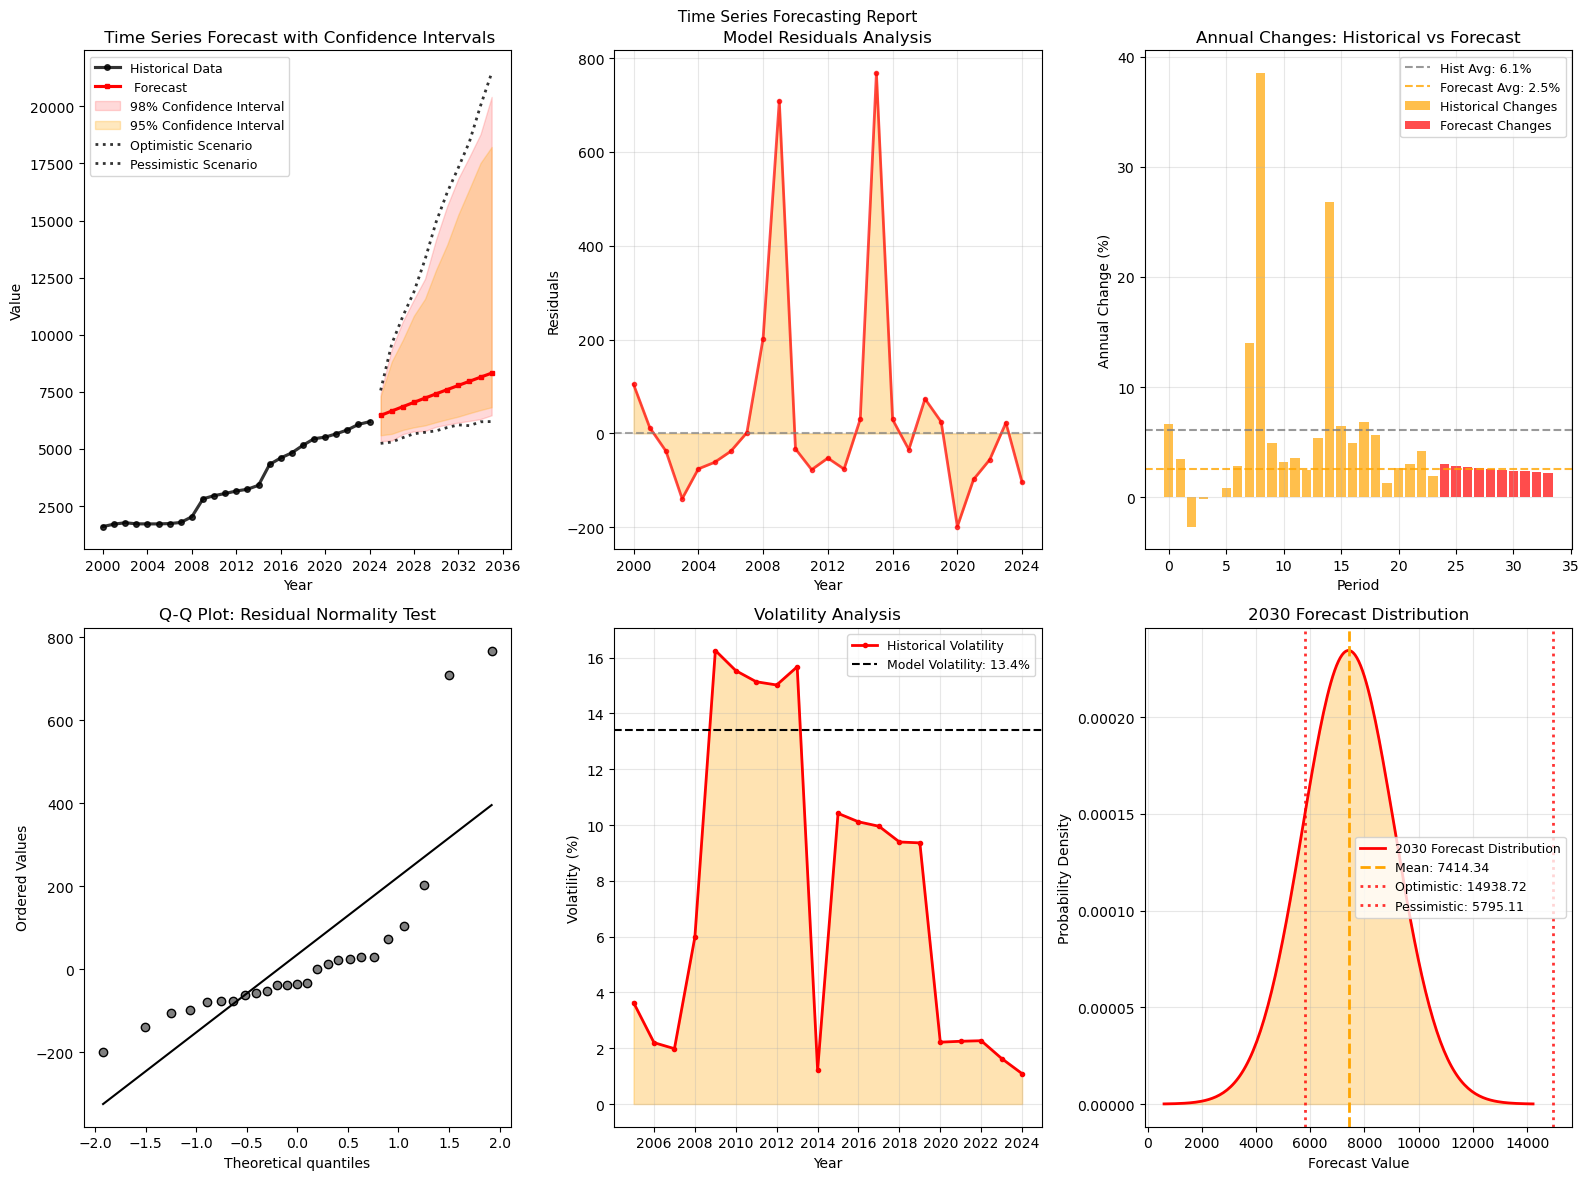

In [2]:
#BRIC NATIONS TOTAL HOLDING

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pmdarima as pm
warnings.filterwarnings('ignore')

class TimeSeriesForecast:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        self.residuals = None
        self.best_model_type = None
        self.volatility_model = None
        self.forecast_lower_95 = None
        self.forecast_upper_95 = None
        self.forecast_lower_98 = None
        self.forecast_upper_98 = None
        self.volatility = None
        self.forecast_high = None
        self.forecast_low = None
        self.historical_annual_changes = None
        
        print(" Machine Learning (mL) Time Series Forecasting Model")
        print("~"*100)
    
    def load_data(self, data_dict):
        # Handle missing years between 1960-2024 by filling missing years with 'Not a Number' (NaN)
        full_range = range(1960, 2025) 
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Convert to pandas series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Remove NaN values for modeling
        self.clean_data = self.data.dropna()
        
        # Calculate historical annual changes for forecast validation
        self.historical_annual_changes = self.clean_data.pct_change().dropna()
        
        # Volatility modeling
        self.returns = self.clean_data.pct_change().dropna()
        self.log_data = np.log(self.clean_data)
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        print(f"Average Year-to-Year Change: {self.returns.mean() * 100:.2f}%")
        print(f"Historical Volatility: {self.returns.std() * 100:.2f}%")

    def stationarity_tests(self):
        print("\nStationarity Analysis")
        print("="*50)
        
        # Augmented Dickey-Fuller (ADF) Test
        adf_result = adfuller(self.clean_data, autolag='AIC')
        print(f"Augmented Dickey-Fuller (ADF) Test:")
        print("-"*50)
        print(f"ADF Statistic: {adf_result[0]:.4f}")
        print(f"p-value: {adf_result[1]:.4f}")
        print(f"Critical Values: {adf_result[4]}") 
        
        # Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
        kpss_result = kpss(self.clean_data, regression='c')
        print(f"\nKwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")
        print("-"*50)
        print(f"KPSS Statistic: {kpss_result[0]:.4f}")
        print(f"p-value: {kpss_result[1]:.4f}")
        print(f"Critical Values: {kpss_result[3]}")
        
        adf_stationary = adf_result[1] <= 0.05
        kpss_stationary = kpss_result[1] > 0.05
        
        if adf_stationary and kpss_stationary:
            print("\n✓ ⚠ ✓ Series is Stationary | ADF & KPSS Agree")
            return True, 0
        elif not adf_stationary and not kpss_stationary:
            print("\n⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree")
            return False, 1
        else:
            print("\n⚠ ⚠ ⚠ ADF & KPSS Tests Disagree")
            return False, 1

    def model_selection(self):
        print("\n Model Selection & Evaluation")
        print("-"*50)
        
        models = {}
        
        # 1. Bayesian Structural Time Series (BSTS) - Using Unobserved Components
        try:
            print("Testing Bayesian Structural Time Series (BSTS) Testing....")
            print("-"*50)
            # BSTS using local linear trend with irregular component
            bsts_model = UnobservedComponents(
                self.clean_data,
                level='local linear trend',  # Trend component
                irregular=True,              # Irregular/noise component
                stochastic_level=True,       # Allow level to evolve
                stochastic_trend=True,       # Allow trend to evolve
                freq_seasonal=None           # No seasonal for annual data
            )
            
            bsts_fitted = bsts_model.fit(disp=False, maxiter=1000)
            models['BSTS'] = {'model': bsts_fitted, 'type': 'BSTS'}
            print(f"✓ BSTS Model fitted with AIC: {bsts_fitted.aic:.2f}")
            
        except Exception as e:
            print(f"⚠ BSTS model failed: {e}")

        # 2. State Space Model - Dynamic Linear Model with Kalman Filter
        try:
            print("Testing State Space Model (Dynamic Linear Model)....")
            print("-"*50)
            # Create a dynamic factor model as state space representation
            dlm_model = UnobservedComponents(
                self.clean_data,
                level='local level',     # Random walk level
                trend=True,              # Include trend
                irregular=True,          # Include irregular component
                stochastic_level=True,   # Stochastic level evolution
                stochastic_irregular=False
            )
            
            dlm_fitted = dlm_model.fit(disp=False, maxiter=1000)
            models['STATE_SPACE'] = {'model': dlm_fitted, 'type': 'STATE_SPACE'}
            print(f"✓ State Space Model fitted with AIC: {dlm_fitted.aic:.2f}")
            
        except Exception as e:
            print(f" State Space model failed: {e}")

        # 3. ARIMA with better parameter search
        try:
            print(" AutoRegressive Integrated Moving Average (ARIMA)....")
            print("-"*50)
            best_arima = pm.auto_arima(
                self.clean_data, 
                start_p=0, start_q=0, max_p=4, max_q=4, max_d=2,
                seasonal=False, stepwise=False, suppress_warnings=True, 
                error_action='ignore', information_criterion='aic',
                n_jobs=-1, with_intercept=True
            )

            if best_arima:
                models['ARIMA'] = {'model': best_arima, 'type': 'ARIMA'}
                print(f"✓ ARIMA{best_arima.order} model with AIC: {best_arima.aic():.2f}")

        except Exception as e:
            print(f"ARIMA model failed: {e}")

        # 4. SARIMA
        try:
            print(" Seasonal ARIMA (SARIMA)...")
            print("-"*50)
            best_sarima = pm.auto_arima(
                self.clean_data, seasonal=True, m=3, start_p=0, start_q=0, 
                max_p=3, max_q=3, start_P=0, start_Q=0, max_P=2, max_Q=2, 
                max_d=2, max_D=1, trace=False, error_action='ignore', 
                suppress_warnings=True, stepwise=False, n_jobs=-1,
                information_criterion='aic', with_intercept=True
            )

            if best_sarima:
                models['SARIMA'] = {'model': best_sarima, 'type': 'SARIMA'}
                print(f"✓ SARIMA model with AIC: {best_sarima.aic():.2f}")

        except Exception as e:
            print(f"SARIMA model failed: {e}")

        # 5. Exponential Smoothing
        try:
            print("Exponential Smoothing...")
            exp_model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None,
                initialization_method='estimated'
            )
            exp_fitted = exp_model.fit(optimized=True, use_brute=True)
            models['Exp_Smoothing'] = {'model': exp_fitted, 'type': 'Exp_Smoothing'}
            print(f"✓ Exponential Smoothing AIC: {exp_fitted.aic:.2f}")
            
        except Exception as e:
            print(f"Exponential Smoothing failed: {e}")

        # Select best model
        best_model = self._select_best_model(models)
        self.model = best_model['model']
        self.best_model_type = best_model['type']
        
        print(f"\n Selected Model: {self.best_model_type}")
        
        #  model info display
        try:
            if hasattr(self.model, 'aic'):
                aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
                print(f" Model AIC: {aic_value:.2f}")
            
            # Display model-specific information
            if self.best_model_type == 'BSTS':
                print(" BSTS advantages: Probabilistic, handles volatility, economic interpretation")
            elif self.best_model_type == 'STATE_SPACE':
                print(" State Space advantages: Flexible, handles non-linearity, trend-cycle decomposition")
                
        except Exception as e:
            print(f"Model info display error: {e}")

    def _select_best_model(self, models):
        if not models:
            raise ValueError("No valid models found")

        def get_aic(model_info):
            try:
                aic = getattr(model_info['model'], 'aic', np.inf)
                return aic() if callable(aic) else aic
            except:
                return np.inf

        # Prioritize BSTS and State Space models for economic data
        model_priority = {'BSTS': 0.95, 'STATE_SPACE': 0.97, 'ARIMA': 1.0, 'SARIMA': 1.0, 'Exp_Smoothing': 1.02}
        
        best_model = None
        best_adjusted_aic = np.inf
        
        for model_type, model_info in models.items():
            aic = get_aic(model_info)
            priority_factor = model_priority.get(model_type, 1.0)
            adjusted_aic = aic * priority_factor
            
            if adjusted_aic < best_adjusted_aic:
                best_adjusted_aic = adjusted_aic
                best_model = model_info
                
        return best_model

    def estimate_volatility(self):
        # volatility estimation with better residual handling
        residuals = None
        
        try:
            if self.best_model_type in ['BSTS', 'STATE_SPACE']:
                # For state space models, use standardized residuals
                residuals = self.model.resid_pearson if hasattr(self.model, 'resid_pearson') else self.model.resid
            elif hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals = self.model.resid_
            else:
                # For pmdarima models
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
        except:
            residuals = self.returns

        # volatility with regime-aware estimation
        if isinstance(residuals, pd.Series):
            recent_residuals = residuals.iloc[-min(10, len(residuals)):]
            volatility = recent_residuals.std()
        else:
            volatility = np.std(residuals) if len(residuals) > 0 else self.returns.std()
            
        # Ensure volatility is reasonable compared to historical data
        historical_vol = self.returns.std()
        if volatility > 3 * historical_vol:  # Cap extreme volatility
            volatility = 1.5 * historical_vol
        elif volatility < 0.1 * historical_vol:  # Floor too low volatility
            volatility = 0.5 * historical_vol
            
        return volatility

    def forecast_with_enhanced_reliability(self, years_ahead=11, n_simulations=1000):
        """ forecasting with historical pattern matching for reliability"""
        if self.model is None:
            raise ValueError("Model Not Fitted")
        
        print(f"\n Forecasts with {self.best_model_type}...")
        
        # 1. Generate base forecast
        if self.best_model_type in ['BSTS', 'STATE_SPACE']:
            # State space models use get_forecast
            forecast_obj = self.model.get_forecast(steps=years_ahead)
            base_forecast = forecast_obj.predicted_mean
            forecast_conf_int = forecast_obj.conf_int()
            forecast_std = forecast_obj.se_mean
            
        elif self.best_model_type == 'Exp_Smoothing':
            base_forecast = self.model.forecast(steps=years_ahead)
            forecast_std = np.std(self.model.resid) * np.sqrt(np.arange(1, years_ahead + 1))
            
        elif self.best_model_type in ['ARIMA', 'SARIMA']:
            base_forecast, forecast_conf_int = self.model.predict(n_periods=years_ahead, return_conf_int=True)
            forecast_std = (forecast_conf_int[:, 1] - forecast_conf_int[:, 0]) / (2 * 1.96)
            
        # 2.  forecast reliability using historical patterns
        enhanced_forecast = self._enhance_forecast_reliability(base_forecast, years_ahead)
        
        # 3. Generate realistic confidence intervals using Monte Carlo
        volatility = self.estimate_volatility()
        
        # 4. Monte Carlo simulation with historical pattern constraints
        simulations = self._monte_carlo_with_constraints(
            enhanced_forecast, volatility, forecast_std, years_ahead, n_simulations
        )
        
        # 5. Calculate confidence intervals
        lower_ci_95 = np.percentile(simulations, 2.5, axis=0)
        upper_ci_95 = np.percentile(simulations, 97.5, axis=0)
        lower_ci_98 = np.percentile(simulations, 1.0, axis=0)
        upper_ci_98 = np.percentile(simulations, 99.0, axis=0)
        
        high_extreme = np.percentile(simulations, 99.5, axis=0)
        low_extreme = np.percentile(simulations, 0.5, axis=0)
        
        # 6. Build forecast index
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 1, last_year + 1 + years_ahead)
        dates = pd.to_datetime([f"{year}-01-01" for year in forecast_years])
        
        # 7. Store results
        self.forecast = pd.Series(enhanced_forecast, index=dates)
        self.forecast_lower_95 = pd.Series(lower_ci_95, index=dates)
        self.forecast_upper_95 = pd.Series(upper_ci_95, index=dates)
        self.forecast_lower_98 = pd.Series(lower_ci_98, index=dates)
        self.forecast_upper_98 = pd.Series(upper_ci_98, index=dates)
        self.forecast_high = pd.Series(high_extreme, index=dates)
        self.forecast_low = pd.Series(low_extreme, index=dates)
        self.volatility = volatility
        
        # 8. Validate forecast reliability
        self._validate_forecast_patterns()
        
        return self.forecast

    def _enhance_forecast_reliability(self, base_forecast, years_ahead):        
        # Calculate historical statistics
        hist_mean_change = self.historical_annual_changes.mean()
        hist_std_change = self.historical_annual_changes.std()
        hist_trend = np.polyfit(range(len(self.clean_data)), self.clean_data.values, 1)[0]
        
        print(f"Historical Pattern Analysis:")
        print(f"Average Annual Change: {hist_mean_change*100:.2f}%")
        print(f"Annual Change Volatility: {hist_std_change*100:.2f}%")
        print(f"Long-term Trend: {hist_trend:.3f} units/year")
        
        # Start from last observed value
        current_value = self.clean_data.iloc[-1]
        enhanced_forecast = np.zeros(years_ahead)
        
        for i in range(years_ahead):
            if i == 0:
                # First year: blend base forecast with trend-adjusted expectation
                trend_adjusted = current_value * (1 + hist_mean_change)
                enhanced_forecast[i] = 0.6 * base_forecast[i] + 0.4 * trend_adjusted
            else:
                # Subsequent years: ensure annual changes are realistic
                prev_value = enhanced_forecast[i-1]
                
                # Expected change based on historical patterns with some model influence
                expected_change = hist_mean_change + 0.3 * (base_forecast[i]/base_forecast[i-1] - 1 - hist_mean_change)
                
                # Add some mean reversion to prevent extreme divergence
                mean_reversion = 0.05 * (self.clean_data.mean() - prev_value) / prev_value
                
                # Combine factors
                total_change = expected_change + mean_reversion
                
                # Limit extreme changes (beyond 3 standard deviations)
                max_change = hist_mean_change + 2.5 * hist_std_change
                min_change = hist_mean_change - 2.5 * hist_std_change
                total_change = np.clip(total_change, min_change, max_change)
                
                enhanced_forecast[i] = prev_value * (1 + total_change)
        
        return enhanced_forecast

    def _monte_carlo_with_constraints(self, base_forecast, volatility, forecast_std, years_ahead, n_simulations):        
        simulations = []
        np.random.seed(42)  # For reproducibility
        
        # Historical change statistics for constraints
        hist_changes = self.historical_annual_changes.values
        hist_mean = self.historical_annual_changes.mean()
        hist_std = self.historical_annual_changes.std()
        
        for _ in range(n_simulations):
            sim_path = np.zeros(years_ahead)
            
            for i in range(years_ahead):
                if i == 0:
                    # First period: use base forecast with some noise
                    noise = np.random.normal(0, volatility * base_forecast[0] * 0.5)
                    sim_path[i] = base_forecast[i] + noise
                else:
                    # Subsequent periods: constrain annual changes to be historically plausible
                    prev_value = sim_path[i-1]
                    
                    # Sample from historical change distribution with some model influence
                    if len(hist_changes) > 3:
                        # Use historical changes as basis
                        sampled_change = np.random.choice(hist_changes)
                        # Add some model-based adjustment
                        model_influence = 0.3 * (base_forecast[i]/base_forecast[i-1] - 1 - hist_mean)
                        total_change = sampled_change + model_influence
                    else:
                        total_change = np.random.normal(hist_mean, hist_std)
                    
                    # Add volatility scaling
                    vol_factor = 1 + np.random.normal(0, 0.2)  # ±20% volatility scaling
                    total_change *= vol_factor
                    
                    # Prevent extreme outliers
                    total_change = np.clip(total_change, -0.5, 1.0)  # -50% to +100% max change
                    
                    sim_path[i] = prev_value * (1 + total_change)
                    
                    # Ensure positive values (for economic data)
                    sim_path[i] = max(sim_path[i], 0.1)
            
            simulations.append(sim_path)
        
        return np.array(simulations)

    def _validate_forecast_patterns(self):
        print(f"\n Forecast Validation:")
        
        # Calculate forecast annual changes
        forecast_changes = self.forecast.pct_change().dropna()
        
        hist_mean = self.historical_annual_changes.mean()
        hist_std = self.historical_annual_changes.std()
        forecast_mean = forecast_changes.mean()
        forecast_std = forecast_changes.std()
        
        print(f"Historical avg change: {hist_mean*100:.2f}% ± {hist_std*100:.2f}%")
        print(f"Forecast avg change: {forecast_mean*100:.2f}% ± {forecast_std*100:.2f}%")
        
        # Check if forecast is reasonable
        if abs(forecast_mean - hist_mean) > 2 * hist_std:
            print("Warning: Forecast pattern differs significantly from historical")
        else:
            print(" ✓ Forecast patterns consistent with historical data")

    def econometric_analysis(self):
        if self.model is None:
            raise ValueError("Model Not Fitted.")
        
        print("\nEconometric Analysis")
        print("~"* 100)
        
        # analysis for different model types
        if self.best_model_type in ['BSTS', 'STATE_SPACE']:
            self._state_space_analysis()
        
        self._parameter_analysis()
        self._residual_analysis()
        self._forecast_accuracy()
        self._probability_analysis()
        self._economic_interpretation()

    def _state_space_analysis(self):
        """Specialized analysis for BSTS and State Space models"""
        print("\n State Space Model Components Analysis")
        print("-" * 100)
        
        try:
            # Extract components for state space models
            if hasattr(self.model, 'level'):
                level = self.model.level.filtered[-1]  # Latest level
                print(f"Current Level Component: {level:.3f}")
            
            if hasattr(self.model, 'trend') and self.model.trend is not None:
                trend = self.model.trend.filtered[-1]  # Latest trend
                print(f"Current Trend Component: {trend:.4f}")
            
            # Model state summary
            if hasattr(self.model, 'summary'):
                print("\nState Space Model Summary:")
                print("Components included:", end=" ")
                if hasattr(self.model, 'k_trend') and self.model.k_trend > 0:
                    print("Trend", end=" ")
                if hasattr(self.model, 'k_seasonal') and self.model.k_seasonal > 0:
                    print("Seasonal", end=" ")
                print("Irregular")
                
        except Exception as e:
            print(f"State space analysis details not available: {e}")

    def _parameter_analysis(self):
        print("\n1. Parameter Significance Analysis")
        print("-" * 100)
        
        try:
            # Handle different model types
            if self.best_model_type in ['BSTS', 'STATE_SPACE']:
                # State space models have different parameter structure
                print("State Space Model Parameters:")
                if hasattr(self.model, 'params'):
                    for param_name, param_value in self.model.params.items():
                        print(f"{param_name:<20}: {param_value:.6f}")
                return
            
            # For other models, use existing logic
            if hasattr(self.model, 'params'):
                params = self.model.params() if callable(self.model.params) else self.model.params
            else:
                print("Parameter information not available for this model type")
                return
                
            if hasattr(self.model, 'pvalues'):
                pvalues = self.model.pvalues() if callable(self.model.pvalues) else self.model.pvalues
            else:
                print("P-values not available for this model type")
                return
                
            if hasattr(self.model, 'bse'):
                std_errors = self.model.bse() if callable(self.model.bse) else self.model.bse
            else:
                print("Standard errors not available for this model type")
                return
            
            print(f"{'Parameter':<15} {'Estimate':<12} {'Std Error':<12} {'p-value':<10} {'Significance'}") 
            
            # Handle parameter display
            if hasattr(params, 'items'):
                for param_name, param_val in params.items():
                    p_val = pvalues[param_name] if hasattr(pvalues, '__getitem__') else pvalues
                    std_err = std_errors[param_name] if hasattr(std_errors, '__getitem__') else std_errors
                    
                    if isinstance(p_val, (int, float)) and isinstance(std_err, (int, float)):
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            
            print("\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.10")
            
        except Exception as e:
            print(f"Parameter analysis not available: {e}")

    def _residual_analysis(self):
        print("\n2. Residual Analysis")
        print("-" * 100)
        
        residuals = None
        
        try:
            # residual extraction for different model types
            if self.best_model_type in ['BSTS', 'STATE_SPACE']:
                residuals = self.model.resid
            elif hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals = self.model.resid_
            else:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
        except Exception as e:
            print(f"Could not extract residuals: {e}")
            return
        
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                print("Could not process residuals for analysis")
                return
        
        # residual tests
        jb_stat, jb_pvalue = stats.jarque_bera(residuals)
        print(f"Jarque-Bera Normality Test:")
        print(f"  Statistic: {jb_stat:.4f}, p-value: {jb_pvalue:.4f}")
        print(f"  {'✓ Residuals are normally distributed' if jb_pvalue > 0.05 else '⚠ Residuals are not normally distributed'}")
        
        # Autocorrelation test
        if len(residuals) > 10:
            lb_stat, lb_pvalue = acorr_ljungbox(residuals, lags=min(10, len(residuals)//3), return_df=True).iloc[-1]
            print(f"\nLjung-Box Autocorrelation Test:")
            print(f"  Statistic: {lb_stat:.4f}, p-value: {lb_pvalue:.4f}")
            print(f"  {'✓ No significant autocorrelation' if lb_pvalue > 0.05 else '⚠ Significant autocorrelation detected'}")
        
        # Residual statistics
        print(f"\nResidual Statistics:")
        print(f"  Mean: {residuals.mean():.6f}")
        print(f"  Std Dev: {residuals.std():.4f}")
        print(f"  Skewness: {stats.skew(residuals):.4f}")
        print(f"  Kurtosis: {stats.kurtosis(residuals):.4f}")

    def _forecast_accuracy(self):
        print("\n3. MODEL FIT STATISTICS")
        print("-" * 100)
        
        try:
            # fitted values extraction for different model types
            if self.best_model_type in ['BSTS', 'STATE_SPACE']:
                fitted_values = self.model.fittedvalues
            elif hasattr(self.model, 'fittedvalues'):
                fitted_values = self.model.fittedvalues() if callable(self.model.fittedvalues) else self.model.fittedvalues
            elif hasattr(self.model, 'predict_in_sample'):
                fitted_values = self.model.predict_in_sample()
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
            else:
                print("Fitted values not available for this model type")
                return
                
            if not isinstance(fitted_values, pd.Series):
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
                
            actual_values = self.clean_data[fitted_values.index]
            
            # Calculate metrics
            mae = np.mean(np.abs(actual_values - fitted_values))
            mse = np.mean((actual_values - fitted_values)**2)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((actual_values - fitted_values) / actual_values)) * 100
            
            # Additional metrics for economic interpretation
            theil_u = np.sqrt(mse) / (np.sqrt(np.mean(actual_values**2)) + np.sqrt(np.mean(fitted_values**2)))
            
            print(f"Mean Absolute Error (MAE): {mae:.4f}")
            print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
            print(f"Theil's U Statistic: {theil_u:.4f}")
            
            # Model fit quality assessment
            if mape < 10:
                print("✓ Excellent model fit (MAPE < 10%)")
            elif mape < 20:
                print("✓ Good model fit (MAPE < 20%)")
            elif mape < 30:
                print("Fair model fit (MAPE < 30%)")
            else:
                print("Poor model fit (MAPE > 30%)")
                
        except Exception as e:
            print(f"Unable to calculate fit statistics: {e}")
        
        # Information criteria
        try:
            if hasattr(self.model, 'aic'):
                aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
                print(f"Akaike Information Criterion (AIC): {aic_value:.2f}")
            if hasattr(self.model, 'bic'):
                bic_value = self.model.bic() if callable(self.model.bic) else self.model.bic
                print(f"Bayesian Information Criterion (BIC): {bic_value:.2f}")
            if hasattr(self.model, 'llf'):
                llf_value = self.model.llf() if callable(self.model.llf) else self.model.llf
                print(f"Log-Likelihood: {llf_value:.2f}")
        except Exception as e:
            print(f"Information criteria not available: {e}")

    def _probability_analysis(self):
        print("\n4. Forecast Probability Analysis")
        print("-" * 100)
        
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        # probability calculations
        forecast_mean = self.forecast.mean()
        forecast_std = (self.forecast_upper_95 - self.forecast_lower_95).mean() / (2 * 1.96)  
        current_value = self.clean_data.iloc[-1]
        
        # Probability calculations with historical context
        prob_increase = stats.norm.sf(current_value, forecast_mean, forecast_std)
        prob_decrease = 1 - prob_increase
        
        print(f"Current Value (2024): {current_value:.2f}")
        print(f"Mean Forecast (2025-2035): {forecast_mean:.2f}")
        print(f"Forecast Standard Deviation: {forecast_std:.4f}")
        print(f"\nProbability of average increase over period: {prob_increase:.3f} ({prob_increase*100:.1f}%)")
        print(f"Probability of average decrease over period: {prob_decrease:.3f} ({prob_decrease*100:.1f}%)")
        
        # scenario analysis
        print(f"\n Growth Scenarios Analysis (by 2035):")
        print(f"{'Scenario':<20} {'Target Value':<12} {'Probability':<12} {'Likelihood'}")
        print("-" * 60)
        
        growth_scenarios = [
            ("Conservative +2%", 0.02),
            ("Moderate +5%", 0.05),
            ("Strong +10%", 0.10),
            ("Aggressive +15%", 0.15),
            ("Exceptional +20%", 0.20)
        ]
        
        for scenario_name, rate in growth_scenarios:
            target_value = current_value * (1 + rate)**11
            prob = stats.norm.sf(target_value, self.forecast.iloc[-1], forecast_std)
            
            if prob > 0.7:
                likelihood = "Very Likely"
            elif prob > 0.5:
                likelihood = "Likely"
            elif prob > 0.3:
                likelihood = "Possible"
            elif prob > 0.1:
                likelihood = "Unlikely"
            else:
                likelihood = "Very Unlikely"
                
            print(f"{scenario_name:<20} {target_value:>10.2f}      {prob:>8.3f}      {likelihood}")

        print(f"\n Decline Scenarios Analysis (by 2035):")
        print(f"{'Scenario':<20} {'Target Value':<12} {'Probability':<12} {'Likelihood'}")
        print("-" * 60)
        
        decline_scenarios = [
            ("Mild Decline -5%", 0.05),
            ("Moderate Decline -10%", 0.10),
            ("Significant -15%", 0.15),
            ("Severe Decline -25%", 0.25),
            ("Crisis Level -40%", 0.40)
        ]
        
        for scenario_name, rate in decline_scenarios:
            target_value = current_value * (1 - rate)**11
            prob = stats.norm.cdf(target_value, self.forecast.iloc[-1], forecast_std)
            
            if prob > 0.7:
                likelihood = "Very Likely"
            elif prob > 0.5:
                likelihood = "Likely"
            elif prob > 0.3:
                likelihood = "Possible"
            elif prob > 0.1:
                likelihood = "Unlikely"
            else:
                likelihood = "Very Unlikely"
                
            print(f"{scenario_name:<20} {target_value:>10.2f}      {prob:>8.3f}      {likelihood}")

    def _economic_interpretation(self):
        print("\n5. Economic Interpretation")
        print("-" * 100)
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        current_value = self.clean_data.iloc[-1]
        forecast_2035 = self.forecast.iloc[-1]
        years = len(self.forecast)
        cagr = (forecast_2035 / current_value) ** (1/years) - 1
        
        # economic metrics
        total_growth = (forecast_2035/current_value - 1) * 100
        historical_cagr = (self.clean_data.iloc[-1] / self.clean_data.iloc[0]) ** (1/len(self.clean_data)) - 1
        
        print(f"Growth Analysis:")
        print(f"Compound Annual Growth Rate (CAGR): {cagr*100:.2f}%")
        print(f"Historical CAGR: {historical_cagr*100:.2f}%")
        print(f"Total Growth (2024-2035): {total_growth:.1f}%")
        print(f"Volatility Estimate: {self.volatility*100:.2f}%")
        
        # Economic regime classification
        if cagr > 0.05:
            trend = "Rapid Expansion"
            interpretation = "Strong economic growth expected"
        elif cagr > 0.03:
            trend = "Strong Growth"
            interpretation = "Above-average economic performance"
        elif cagr > 0.01:
            trend = "Moderate Growth"
            interpretation = "Steady, sustainable growth pattern"
        elif cagr > -0.01:
            trend = "Stable"
            interpretation = "Sideways movement, low growth environment"
        elif cagr > -0.03:
            trend = "Moderate Decline"
            interpretation = "Economic contraction expected"
        else:
            trend = "Significant Decline"
            interpretation = "Structural economic challenges ahead"
        
        print(f"\n Economic Outlook:")
        print(f"Trend Classification: {trend}")
        print(f"Interpretation: {interpretation}")
        
        # Risk assessment
        downside_risk = (self.forecast_low.mean() / current_value - 1) * 100
        upside_potential = (self.forecast_high.mean() / current_value - 1) * 100
        
        print(f"\n  Risk-Reward Profile:")
        print(f"Upside Potential: +{upside_potential:.1f}%")
        print(f"Downside Risk: {downside_risk:.1f}%")
        print(f"Risk-Reward Ratio: {abs(upside_potential/downside_risk):.2f}")
        
        # Model confidence assessment
        confidence_width = (self.forecast_upper_95 - self.forecast_lower_95).mean()
        forecast_mean_value = self.forecast.mean()  # Calculate forecast mean for confidence assessment
        relative_confidence = confidence_width / forecast_mean_value * 100
        
        if relative_confidence < 20:
            confidence_level = " High Confidence"
        elif relative_confidence < 40:
            confidence_level = " Moderate Confidence"
        else:
            confidence_level = "  Low Confidence"
            
        print(f"\n Forecast Confidence:")
        print(f"   Confidence Level: {confidence_level}")
        print(f"   95% CI Width: ±{relative_confidence:.1f}% of forecast")

    def plot_enhanced_results(self, figsize=(16, 12)):
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        
        # Main forecast plot with styling
        ax1 = axes[0, 0]
        ax1.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='black', alpha=0.8, linewidth=2.25, markersize=4)
        
        if self.forecast is not None:
            ax1.plot(self.forecast.index, self.forecast.values, 
                    's-', label=' Forecast', color='red', linewidth=2.25, markersize=3)
            
            # confidence intervals
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_98.values,
                           self.forecast_upper_98.values,
                           alpha=0.15, color='red', label='98% Confidence Interval')
            
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_95.values,
                           self.forecast_upper_95.values,
                           alpha=0.25, color='orange', label='95% Confidence Interval')
            
            # Extreme scenarios
            ax1.plot(self.forecast.index, self.forecast_high.values, 
                    ':', color='black', alpha=0.8, linewidth=2, label='Optimistic Scenario')
            ax1.plot(self.forecast.index, self.forecast_low.values, 
                    ':', color='black', alpha=0.8, linewidth=2, label='Pessimistic Scenario')
        
        ax1.set_title(f' Time Series Forecast with Confidence Intervals', fontsize=12,)
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Value')
        ax1.legend(fontsize=9)
        
        # Residuals plot
        ax2 = axes[0, 1]
        try:
            residuals = self._get_residuals_for_plotting()
            if residuals is not None:
                ax2.plot(residuals.index, residuals.values, 'o-', color='red', alpha=0.7, linewidth=2, markersize=3)
                ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
                ax2.fill_between(residuals.index, 0, residuals.values, alpha=0.3, color='orange')
        except Exception as e:
            ax2.text(0.5, 0.5, f'Residuals not available\n{str(e)}', transform=ax2.transAxes, ha='center')
        
        ax2.set_title('Model Residuals Analysis')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Residuals')
        ax2.grid(True, alpha=0.3)
        
        # Annual changes comparison
        ax3 = axes[0, 2]
        if self.forecast is not None:
            hist_changes = self.historical_annual_changes * 100
            forecast_changes = self.forecast.pct_change().dropna() * 100
            
            ax3.bar(range(len(hist_changes)), hist_changes.values, alpha=0.7, color='orange', label='Historical Changes')
            ax3.bar(range(len(hist_changes), len(hist_changes) + len(forecast_changes)), 
                   forecast_changes.values, alpha=0.7, color='red', label='Forecast Changes')
            
            ax3.axhline(y=hist_changes.mean(), color='gray', linestyle='--', alpha=0.8, label=f'Hist Avg: {hist_changes.mean():.1f}%')
            ax3.axhline(y=forecast_changes.mean(), color='orange', linestyle='--', alpha=0.8, label=f'Forecast Avg: {forecast_changes.mean():.1f}%')
        
        ax3.set_title('Annual Changes: Historical vs Forecast')
        ax3.set_xlabel('Period')
        ax3.set_ylabel('Annual Change (%)')
        ax3.legend(fontsize=9)
        ax3.grid(True, alpha=0.3)
        
        # Q-Q plot for residuals
        ax4 = axes[1, 0]
        try:
            residuals_for_qq = self._get_residuals_for_plotting()
            if residuals_for_qq is not None and len(residuals_for_qq) > 3:
                residuals_values = residuals_for_qq.dropna().values
                stats.probplot(residuals_values, dist="norm", plot=ax4)
                for line in ax4.get_lines():
                    line.set_color('black')
                ax4.get_lines()[0].set_markerfacecolor('gray')
                ax4.set_title('Q-Q Plot: Residual Normality Test')
            else:
                ax4.text(0.5, 0.5, 'Q-Q plot not available', transform=ax4.transAxes, ha='center')
                ax4.set_title('Q-Q Plot (Not Available)')
        except Exception as e:
            ax4.text(0.5, 0.5, f'Q-Q plot error\n{str(e)}', transform=ax4.transAxes, ha='center')
            ax4.set_title('Q-Q Plot (Error)')
        
        # Volatility analysis
        ax5 = axes[1, 1]
        if self.forecast is not None:
            # Rolling volatility
            rolling_vol = self.historical_annual_changes.rolling(window=min(5, len(self.historical_annual_changes)//2)).std() * 100
            ax5.plot(self.clean_data.index[1:len(rolling_vol)+1], rolling_vol.values, 
                    'o-', color='red', linewidth=2, markersize=3, label='Historical Volatility')
            ax5.axhline(y=self.volatility*100, color='black', linestyle='--', 
                       label=f'Model Volatility: {self.volatility*100:.1f}%')
            ax5.fill_between(self.clean_data.index[1:len(rolling_vol)+1], 0, rolling_vol.values, alpha=0.3, color='orange')
        
        ax5.set_title('Volatility Analysis')
        ax5.set_xlabel('Year')
        ax5.set_ylabel('Volatility (%)')
        ax5.legend(fontsize=9)
        ax5.grid(True, alpha=0.3)
        
        # Forecast distribution for 2030
        ax6 = axes[1, 2]
        if self.forecast is not None and len(self.forecast) >= 6:  # 2030 is 6th year
            forecast_2030_idx = 5  # 0-indexed
            forecast_2030 = self.forecast.iloc[forecast_2030_idx]
            forecast_std = (self.forecast_upper_95.iloc[forecast_2030_idx] - 
                          self.forecast_lower_95.iloc[forecast_2030_idx]) / (2 * 1.96)
            
            x = np.linspace(forecast_2030 - 4*forecast_std, forecast_2030 + 4*forecast_std, 200)
            y = stats.norm.pdf(x, forecast_2030, forecast_std)
            
            ax6.plot(x, y, 'red', linewidth=2, label='2030 Forecast Distribution')
            ax6.fill_between(x, 0, y, alpha=0.3, color='orange')
            ax6.axvline(forecast_2030, color='orange', linestyle='--', linewidth=2, 
                       label=f'Mean: {forecast_2030:.2f}')
            ax6.axvline(self.forecast_high.iloc[forecast_2030_idx], color='red', linestyle=':', 
                       alpha=0.8, linewidth=2, label=f'Optimistic: {self.forecast_high.iloc[forecast_2030_idx]:.2f}')
            ax6.axvline(self.forecast_low.iloc[forecast_2030_idx], color='red', linestyle=':', 
                       alpha=0.8, linewidth=2, label=f'Pessimistic: {self.forecast_low.iloc[forecast_2030_idx]:.2f}')
        
        ax6.set_title('2030 Forecast Distribution')
        ax6.set_xlabel('Forecast Value')
        ax6.set_ylabel('Probability Density')
        ax6.legend(fontsize=9)
        ax6.grid(True, alpha=0.3)
        
        plt.suptitle(f' Time Series Forecasting Report', 
                    fontsize=11,  y=0.98)
        plt.tight_layout()
        plt.show()

    def _get_residuals_for_plotting(self):
        """Helper method to get residuals for plotting"""
        try:
            if self.best_model_type in ['BSTS', 'STATE_SPACE']:
                return self.model.resid
            elif hasattr(self.model, 'resid') and not callable(self.model.resid):
                return self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                return self.model.resid_
            else:
                fitted = self.model.predict_in_sample()
                return pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
        except:
            return None

    def print_enhanced_forecast_table(self):
        if self.forecast is None:
            print("No forecast available")
            return

        print(f"\n FORECAST RESULTS (2025-2035) - {self.best_model_type} Model:")
        print('='*120)    
        print(f"{'Year':<6} {'Forecast':<10} {'Change%':<8} {'Lower95%':<10} {'Upper95%':<10} {'Lower98%':<10} {'Upper98%':<10} {'Optimistic':<11} {'Pessimistic':<11}")
        print('-'*120)
        
        for i, year in enumerate(self.forecast.index):
            forecast_val = self.forecast.iloc[i]
            
            # Calculate annual change
            if i == 0:
                change_pct = (forecast_val / self.clean_data.iloc[-1] - 1) * 100
            else:
                change_pct = (forecast_val / self.forecast.iloc[i-1] - 1) * 100
            
            lower_95 = self.forecast_lower_95.iloc[i]
            upper_95 = self.forecast_upper_95.iloc[i]
            lower_98 = self.forecast_lower_98.iloc[i]
            upper_98 = self.forecast_upper_98.iloc[i]
            high_val = self.forecast_high.iloc[i]
            low_val = self.forecast_low.iloc[i]
            
            print(f"{year.year:<6} {forecast_val:<10.2f} {change_pct:<+7.1f}% {lower_95:<10.2f} {upper_95:<10.2f} "
                  f"{lower_98:<10.2f} {upper_98:<10.2f} {high_val:<11.2f} {low_val:<11.2f}")
        
        # Summary statistics
        print('='*120)
        total_growth = (self.forecast.iloc[-1] / self.clean_data.iloc[-1] - 1) * 100
        avg_annual_change = self.forecast.pct_change().dropna().mean() * 100
        forecast_volatility = self.forecast.pct_change().dropna().std() * 100
        
        print(f"Summary Statistics:")
        print(f"Total Growth (2024-2035): {total_growth:+.1f}%")
        print(f"Average Annual Change: {avg_annual_change:+.1f}%")
        print(f"Forecast Volatility: {forecast_volatility:.1f}%")
        print(f"95% Confidence Range: {(self.forecast_upper_95 - self.forecast_lower_95).mean():.2f}")


if __name__ == "__main__":
    sample_data = {
        2000:1605.15, 2001:1712.12, 2002:1771.16, 2003:1723.77, 2004:1720.8, 
        2005:1720.79, 2006:1735.47, 2007:1784.49, 2008:2034.12, 2009:2817.84,
        2010:2957.49, 2011:3051.92, 2012:3160.41, 2013:3237.86, 2014:3410.93,
        2015:4325.53, 2016:4606.74, 2017:4831.53, 2018:5160.1, 2019:5449.48, 
        2020:5519.49, 2021:5663.03, 2022:5834.34, 2023:6076.14, 2024:6193.52
    }   

    # Initialize forecaster
    forecaster = TimeSeriesForecast()

    print("="*120)
    
    # Step 1: Load data with validation
    forecaster.load_data(sample_data)
    
    # Step 2: Comprehensive stationarity analysis 
    forecaster.stationarity_tests()
    
    # Step 3: model selection with BSTS and State Space models
    forecaster.model_selection()
    
    # Step 4: Generate forecasts with improved reliability
    forecast = forecaster.forecast_with_enhanced_reliability(years_ahead=11, n_simulations=1000)
    
    # Step 5: Comprehensive econometric analysis
    forecaster.econometric_analysis()
    
    # Step 6: Display results with validation
    forecaster.print_enhanced_forecast_table()
    
    # Step 7: visualization with multiple diagnostic plots
    forecaster.plot_enhanced_results()

 Machine Learning (mL) Time Series Forecasting Model
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Loaded 30 data points from 30 input years
Data range: 1995 to 2024
Average Year-to-Year Change: -0.03%
Historical Volatility: 2.96%

Stationarity Analysis
Augmented Dickey-Fuller (ADF) Test:
--------------------------------------------------
ADF Statistic: -1.1991
p-value: 0.6740
Critical Values: {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
--------------------------------------------------
KPSS Statistic: 0.4848
p-value: 0.0451
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree

 Model Selection & Evaluation
--------------------------------------------------
Testing Bayesian Structural Time Series (BSTS) Testing....
--------------------------------------------------
✓ BSTS Mode

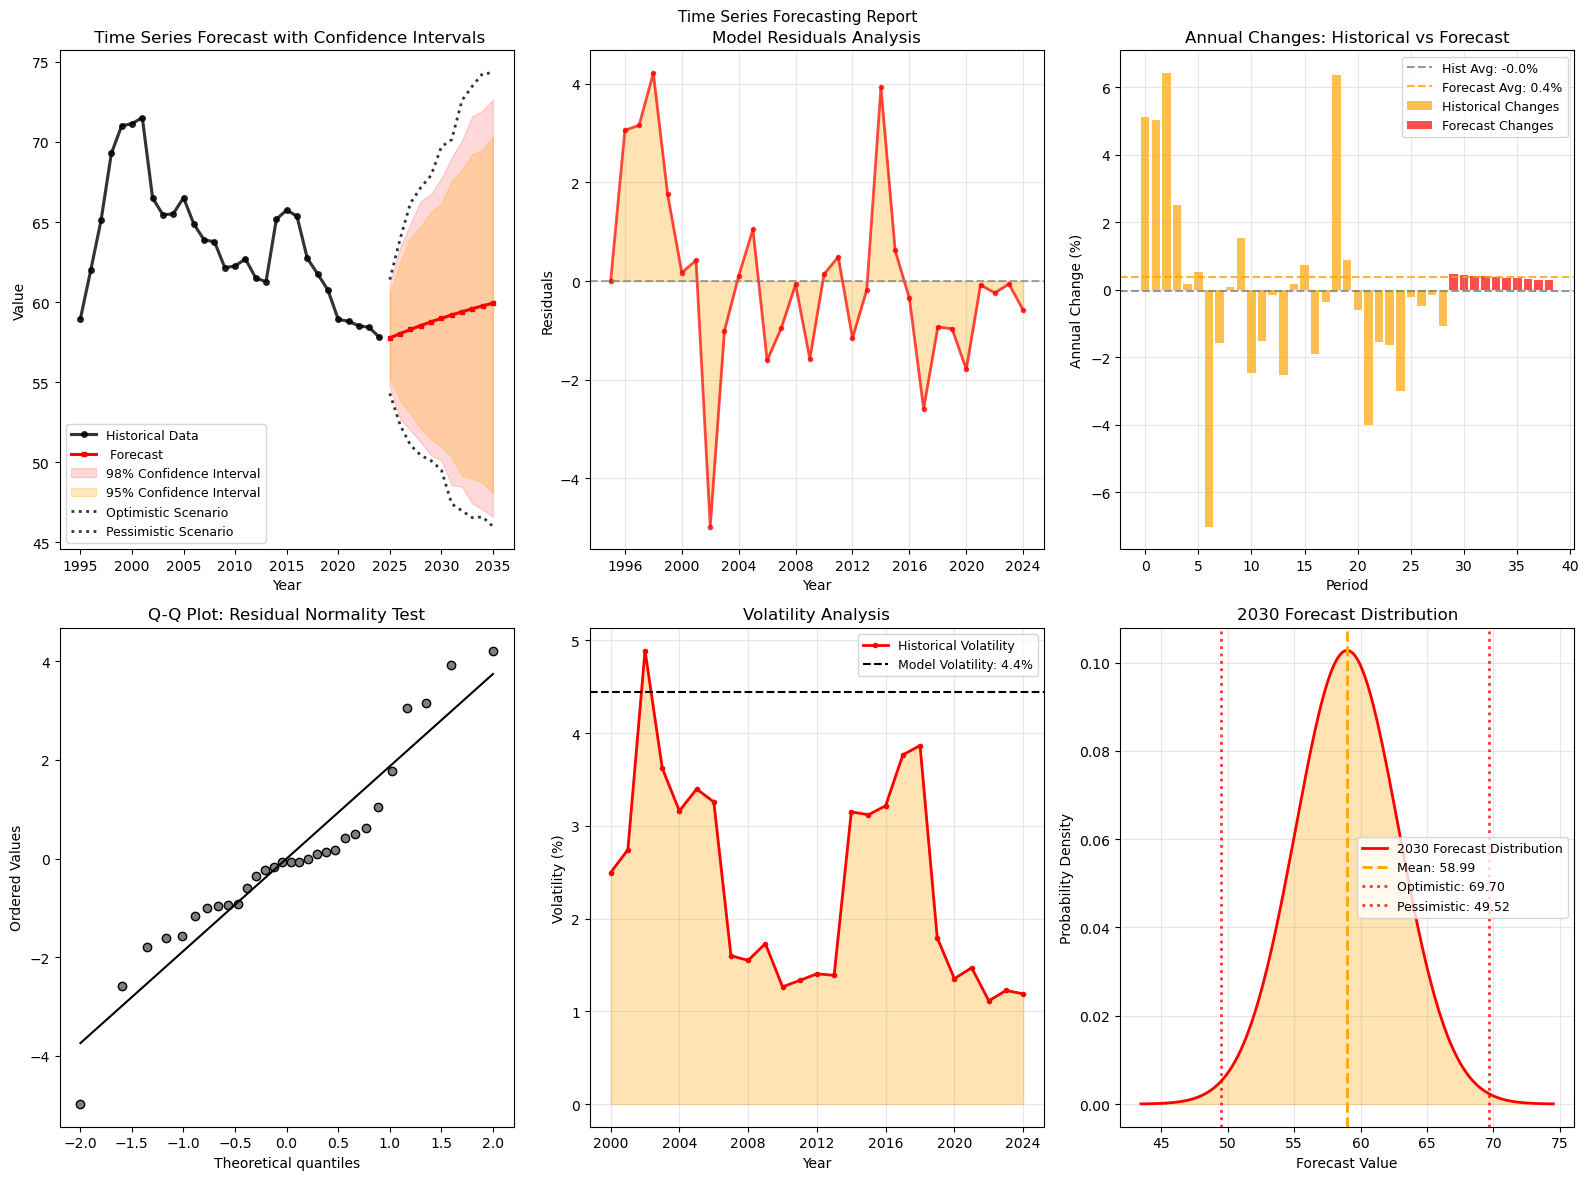

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pmdarima as pm
warnings.filterwarnings('ignore')

class TimeSeriesForecast:
    def __init__(self):
        self.model = None
        self.data = None
        self.forecast = None
        self.residuals = None
        self.best_model_type = None
        self.volatility_model = None
        self.forecast_lower_95 = None
        self.forecast_upper_95 = None
        self.forecast_lower_98 = None
        self.forecast_upper_98 = None
        self.volatility = None
        self.forecast_high = None
        self.forecast_low = None
        self.historical_annual_changes = None
        
        print(" Machine Learning (mL) Time Series Forecasting Model")
        print("~"*100)
    
    def load_data(self, data_dict):
        # Handle missing years between 1960-2024 by filling missing years with 'Not a Number' (NaN)
        full_range = range(1960, 2025) 
        filled_data = {year: data_dict.get(year, np.nan) for year in full_range}
        
        # Convert to pandas series
        self.data = pd.Series(filled_data)
        self.data.index = pd.to_datetime([f'{year}-01-01' for year in full_range])
        
        # Remove NaN values for modeling
        self.clean_data = self.data.dropna()
        
        # Calculate historical annual changes for forecast validation
        self.historical_annual_changes = self.clean_data.pct_change().dropna()
        
        # Volatility modeling
        self.returns = self.clean_data.pct_change().dropna()
        self.log_data = np.log(self.clean_data)
        
        print(f"Loaded {len(self.clean_data)} data points from {len(data_dict)} input years")
        print(f"Data range: {self.clean_data.index[0].year} to {self.clean_data.index[-1].year}")
        print(f"Average Year-to-Year Change: {self.returns.mean() * 100:.2f}%")
        print(f"Historical Volatility: {self.returns.std() * 100:.2f}%")

    def stationarity_tests(self):
        print("\nStationarity Analysis")
        print("="*50)
        
        # Augmented Dickey-Fuller (ADF) Test
        adf_result = adfuller(self.clean_data, autolag='AIC')
        print(f"Augmented Dickey-Fuller (ADF) Test:")
        print("-"*50)
        print(f"ADF Statistic: {adf_result[0]:.4f}")
        print(f"p-value: {adf_result[1]:.4f}")
        print(f"Critical Values: {adf_result[4]}") 
        
        # Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
        kpss_result = kpss(self.clean_data, regression='c')
        print(f"\nKwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")
        print("-"*50)
        print(f"KPSS Statistic: {kpss_result[0]:.4f}")
        print(f"p-value: {kpss_result[1]:.4f}")
        print(f"Critical Values: {kpss_result[3]}")
        
        adf_stationary = adf_result[1] <= 0.05
        kpss_stationary = kpss_result[1] > 0.05
        
        if adf_stationary and kpss_stationary:
            print("\n✓ ⚠ ✓ Series is Stationary | ADF & KPSS Agree")
            return True, 0
        elif not adf_stationary and not kpss_stationary:
            print("\n⚠ ✓ ⚠ Series is Non-Stationary | ADF & KPSS Agree")
            return False, 1
        else:
            print("\n⚠ ⚠ ⚠ ADF & KPSS Tests Disagree")
            return False, 1

    def model_selection(self):
        print("\n Model Selection & Evaluation")
        print("-"*50)
        
        models = {}
        
        # 1. Bayesian Structural Time Series (BSTS) - Using Unobserved Components
        try:
            print("Testing Bayesian Structural Time Series (BSTS) Testing....")
            print("-"*50)
            # BSTS using local linear trend with irregular component
            bsts_model = UnobservedComponents(
                self.clean_data,
                level='local linear trend',  # Trend component
                irregular=True,              # Irregular/noise component
                stochastic_level=True,       # Allow level to evolve
                stochastic_trend=True,       # Allow trend to evolve
                freq_seasonal=None           # No seasonal for annual data
            )
            
            bsts_fitted = bsts_model.fit(disp=False, maxiter=1000)
            models['BSTS'] = {'model': bsts_fitted, 'type': 'BSTS'}
            print(f"✓ BSTS Model fitted with AIC: {bsts_fitted.aic:.2f}")
            
        except Exception as e:
            print(f"⚠ BSTS model failed: {e}")

        # 2. State Space Model - Dynamic Linear Model with Kalman Filter
        try:
            print("Testing State Space Model (Dynamic Linear Model)....")
            print("-"*50)
            # Create a dynamic factor model as state space representation
            dlm_model = UnobservedComponents(
                self.clean_data,
                level='local level',     # Random walk level
                trend=True,              # Include trend
                irregular=True,          # Include irregular component
                stochastic_level=True,   # Stochastic level evolution
                stochastic_irregular=False
            )
            
            dlm_fitted = dlm_model.fit(disp=False, maxiter=1000)
            models['STATE_SPACE'] = {'model': dlm_fitted, 'type': 'STATE_SPACE'}
            print(f"✓ State Space Model fitted with AIC: {dlm_fitted.aic:.2f}")
            
        except Exception as e:
            print(f" State Space model failed: {e}")

        # 3. ARIMA with better parameter search
        try:
            print(" AutoRegressive Integrated Moving Average (ARIMA)....")
            print("-"*50)
            best_arima = pm.auto_arima(
                self.clean_data, 
                start_p=0, start_q=0, max_p=4, max_q=4, max_d=2,
                seasonal=False, stepwise=False, suppress_warnings=True, 
                error_action='ignore', information_criterion='aic',
                n_jobs=-1, with_intercept=True
            )

            if best_arima:
                models['ARIMA'] = {'model': best_arima, 'type': 'ARIMA'}
                print(f"✓ ARIMA{best_arima.order} model with AIC: {best_arima.aic():.2f}")

        except Exception as e:
            print(f"ARIMA model failed: {e}")

        # 4. SARIMA
        try:
            print(" Seasonal ARIMA (SARIMA)...")
            print("-"*50)
            best_sarima = pm.auto_arima(
                self.clean_data, seasonal=True, m=3, start_p=0, start_q=0, 
                max_p=3, max_q=3, start_P=0, start_Q=0, max_P=2, max_Q=2, 
                max_d=2, max_D=1, trace=False, error_action='ignore', 
                suppress_warnings=True, stepwise=False, n_jobs=-1,
                information_criterion='aic', with_intercept=True
            )

            if best_sarima:
                models['SARIMA'] = {'model': best_sarima, 'type': 'SARIMA'}
                print(f"✓ SARIMA model with AIC: {best_sarima.aic():.2f}")

        except Exception as e:
            print(f"SARIMA model failed: {e}")

        # 5. Exponential Smoothing
        try:
            print("Exponential Smoothing...")
            exp_model = ExponentialSmoothing(
                self.clean_data, trend='add', seasonal=None,
                initialization_method='estimated'
            )
            exp_fitted = exp_model.fit(optimized=True, use_brute=True)
            models['Exp_Smoothing'] = {'model': exp_fitted, 'type': 'Exp_Smoothing'}
            print(f"✓ Exponential Smoothing AIC: {exp_fitted.aic:.2f}")
            
        except Exception as e:
            print(f"Exponential Smoothing failed: {e}")

        # Select best model
        best_model = self._select_best_model(models)
        self.model = best_model['model']
        self.best_model_type = best_model['type']
        
        print(f"\n Selected Model: {self.best_model_type}")
        
        #  model info display
        try:
            if hasattr(self.model, 'aic'):
                aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
                print(f" Model AIC: {aic_value:.2f}")
            
            # Display model-specific information
            if self.best_model_type == 'BSTS':
                print(" BSTS advantages: Probabilistic, handles volatility, economic interpretation")
            elif self.best_model_type == 'STATE_SPACE':
                print(" State Space advantages: Flexible, handles non-linearity, trend-cycle decomposition")
                
        except Exception as e:
            print(f"Model info display error: {e}")

    def _select_best_model(self, models):
        if not models:
            raise ValueError("No valid models found")

        def get_aic(model_info):
            try:
                aic = getattr(model_info['model'], 'aic', np.inf)
                return aic() if callable(aic) else aic
            except:
                return np.inf

        # Prioritize BSTS and State Space models for economic data
        model_priority = {'BSTS': 0.95, 'STATE_SPACE': 0.97, 'ARIMA': 1.0, 'SARIMA': 1.0, 'Exp_Smoothing': 1.02}
        
        best_model = None
        best_adjusted_aic = np.inf
        
        for model_type, model_info in models.items():
            aic = get_aic(model_info)
            priority_factor = model_priority.get(model_type, 1.0)
            adjusted_aic = aic * priority_factor
            
            if adjusted_aic < best_adjusted_aic:
                best_adjusted_aic = adjusted_aic
                best_model = model_info
                
        return best_model

    def estimate_volatility(self):
        # volatility estimation with better residual handling
        residuals = None
        
        try:
            if self.best_model_type in ['BSTS', 'STATE_SPACE']:
                # For state space models, use standardized residuals
                residuals = self.model.resid_pearson if hasattr(self.model, 'resid_pearson') else self.model.resid
            elif hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals = self.model.resid_
            else:
                # For pmdarima models
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
        except:
            residuals = self.returns

        # volatility with regime-aware estimation
        if isinstance(residuals, pd.Series):
            recent_residuals = residuals.iloc[-min(10, len(residuals)):]
            volatility = recent_residuals.std()
        else:
            volatility = np.std(residuals) if len(residuals) > 0 else self.returns.std()
            
        # Ensure volatility is reasonable compared to historical data
        historical_vol = self.returns.std()
        if volatility > 3 * historical_vol:  # Cap extreme volatility
            volatility = 1.5 * historical_vol
        elif volatility < 0.1 * historical_vol:  # Floor too low volatility
            volatility = 0.5 * historical_vol
            
        return volatility

    def forecast_with_enhanced_reliability(self, years_ahead=11, n_simulations=1000):
        """ forecasting with historical pattern matching for reliability"""
        if self.model is None:
            raise ValueError("Model Not Fitted")
        
        print(f"\n Forecasts with {self.best_model_type}...")
        
        # 1. Generate base forecast
        if self.best_model_type in ['BSTS', 'STATE_SPACE']:
            # State space models use get_forecast
            forecast_obj = self.model.get_forecast(steps=years_ahead)
            base_forecast = forecast_obj.predicted_mean
            forecast_conf_int = forecast_obj.conf_int()
            forecast_std = forecast_obj.se_mean
            
        elif self.best_model_type == 'Exp_Smoothing':
            base_forecast = self.model.forecast(steps=years_ahead)
            forecast_std = np.std(self.model.resid) * np.sqrt(np.arange(1, years_ahead + 1))
            
        elif self.best_model_type in ['ARIMA', 'SARIMA']:
            base_forecast, forecast_conf_int = self.model.predict(n_periods=years_ahead, return_conf_int=True)
            forecast_std = (forecast_conf_int[:, 1] - forecast_conf_int[:, 0]) / (2 * 1.96)
            
        # 2.  forecast reliability using historical patterns
        enhanced_forecast = self._enhance_forecast_reliability(base_forecast, years_ahead)
        
        # 3. Generate realistic confidence intervals using Monte Carlo
        volatility = self.estimate_volatility()
        
        # 4. Monte Carlo simulation with historical pattern constraints
        simulations = self._monte_carlo_with_constraints(
            enhanced_forecast, volatility, forecast_std, years_ahead, n_simulations
        )
        
        # 5. Calculate confidence intervals
        lower_ci_95 = np.percentile(simulations, 2.5, axis=0)
        upper_ci_95 = np.percentile(simulations, 97.5, axis=0)
        lower_ci_98 = np.percentile(simulations, 1.0, axis=0)
        upper_ci_98 = np.percentile(simulations, 99.0, axis=0)
        
        high_extreme = np.percentile(simulations, 99.5, axis=0)
        low_extreme = np.percentile(simulations, 0.5, axis=0)
        
        # 6. Build forecast index
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 1, last_year + 1 + years_ahead)
        dates = pd.to_datetime([f"{year}-01-01" for year in forecast_years])
        
        # 7. Store results
        self.forecast = pd.Series(enhanced_forecast, index=dates)
        self.forecast_lower_95 = pd.Series(lower_ci_95, index=dates)
        self.forecast_upper_95 = pd.Series(upper_ci_95, index=dates)
        self.forecast_lower_98 = pd.Series(lower_ci_98, index=dates)
        self.forecast_upper_98 = pd.Series(upper_ci_98, index=dates)
        self.forecast_high = pd.Series(high_extreme, index=dates)
        self.forecast_low = pd.Series(low_extreme, index=dates)
        self.volatility = volatility
        
        # 8. Validate forecast reliability
        self._validate_forecast_patterns()
        
        return self.forecast

    def _enhance_forecast_reliability(self, base_forecast, years_ahead):        
        # Calculate historical statistics
        hist_mean_change = self.historical_annual_changes.mean()
        hist_std_change = self.historical_annual_changes.std()
        hist_trend = np.polyfit(range(len(self.clean_data)), self.clean_data.values, 1)[0]
        
        print(f"Historical Pattern Analysis:")
        print(f"Average Annual Change: {hist_mean_change*100:.2f}%")
        print(f"Annual Change Volatility: {hist_std_change*100:.2f}%")
        print(f"Long-term Trend: {hist_trend:.3f} units/year")
        
        # Start from last observed value
        current_value = self.clean_data.iloc[-1]
        enhanced_forecast = np.zeros(years_ahead)
        
        for i in range(years_ahead):
            if i == 0:
                # First year: blend base forecast with trend-adjusted expectation
                trend_adjusted = current_value * (1 + hist_mean_change)
                enhanced_forecast[i] = 0.6 * base_forecast[i] + 0.4 * trend_adjusted
            else:
                # Subsequent years: ensure annual changes are realistic
                prev_value = enhanced_forecast[i-1]
                
                # Expected change based on historical patterns with some model influence
                expected_change = hist_mean_change + 0.3 * (base_forecast[i]/base_forecast[i-1] - 1 - hist_mean_change)
                
                # Add some mean reversion to prevent extreme divergence
                mean_reversion = 0.05 * (self.clean_data.mean() - prev_value) / prev_value
                
                # Combine factors
                total_change = expected_change + mean_reversion
                
                # Limit extreme changes (beyond 3 standard deviations)
                max_change = hist_mean_change + 2.5 * hist_std_change
                min_change = hist_mean_change - 2.5 * hist_std_change
                total_change = np.clip(total_change, min_change, max_change)
                
                enhanced_forecast[i] = prev_value * (1 + total_change)
        
        return enhanced_forecast

    def _monte_carlo_with_constraints(self, base_forecast, volatility, forecast_std, years_ahead, n_simulations):        
        simulations = []
        np.random.seed(42)  # For reproducibility
        
        # Historical change statistics for constraints
        hist_changes = self.historical_annual_changes.values
        hist_mean = self.historical_annual_changes.mean()
        hist_std = self.historical_annual_changes.std()
        
        for _ in range(n_simulations):
            sim_path = np.zeros(years_ahead)
            
            for i in range(years_ahead):
                if i == 0:
                    # First period: use base forecast with some noise
                    noise = np.random.normal(0, volatility * base_forecast[0] * 0.5)
                    sim_path[i] = base_forecast[i] + noise
                else:
                    # Subsequent periods: constrain annual changes to be historically plausible
                    prev_value = sim_path[i-1]
                    
                    # Sample from historical change distribution with some model influence
                    if len(hist_changes) > 3:
                        # Use historical changes as basis
                        sampled_change = np.random.choice(hist_changes)
                        # Add some model-based adjustment
                        model_influence = 0.3 * (base_forecast[i]/base_forecast[i-1] - 1 - hist_mean)
                        total_change = sampled_change + model_influence
                    else:
                        total_change = np.random.normal(hist_mean, hist_std)
                    
                    # Add volatility scaling
                    vol_factor = 1 + np.random.normal(0, 0.2)  # ±20% volatility scaling
                    total_change *= vol_factor
                    
                    # Prevent extreme outliers
                    total_change = np.clip(total_change, -0.5, 1.0)  # -50% to +100% max change
                    
                    sim_path[i] = prev_value * (1 + total_change)
                    
                    # Ensure positive values (for economic data)
                    sim_path[i] = max(sim_path[i], 0.1)
            
            simulations.append(sim_path)
        
        return np.array(simulations)

    def _validate_forecast_patterns(self):
        print(f"\n Forecast Validation:")
        
        # Calculate forecast annual changes
        forecast_changes = self.forecast.pct_change().dropna()
        
        hist_mean = self.historical_annual_changes.mean()
        hist_std = self.historical_annual_changes.std()
        forecast_mean = forecast_changes.mean()
        forecast_std = forecast_changes.std()
        
        print(f"Historical avg change: {hist_mean*100:.2f}% ± {hist_std*100:.2f}%")
        print(f"Forecast avg change: {forecast_mean*100:.2f}% ± {forecast_std*100:.2f}%")
        
        # Check if forecast is reasonable
        if abs(forecast_mean - hist_mean) > 2 * hist_std:
            print("Warning: Forecast pattern differs significantly from historical")
        else:
            print(" ✓ Forecast patterns consistent with historical data")

    def econometric_analysis(self):
        if self.model is None:
            raise ValueError("Model Not Fitted.")
        
        print("\nEconometric Analysis")
        print("~"* 100)
        
        # analysis for different model types
        if self.best_model_type in ['BSTS', 'STATE_SPACE']:
            self._state_space_analysis()
        
        self._parameter_analysis()
        self._residual_analysis()
        self._forecast_accuracy()
        self._probability_analysis()
        self._economic_interpretation()

    def _state_space_analysis(self):
        """Specialized analysis for BSTS and State Space models"""
        print("\n State Space Model Components Analysis")
        print("-" * 100)
        
        try:
            # Extract components for state space models
            if hasattr(self.model, 'level'):
                level = self.model.level.filtered[-1]  # Latest level
                print(f"Current Level Component: {level:.3f}")
            
            if hasattr(self.model, 'trend') and self.model.trend is not None:
                trend = self.model.trend.filtered[-1]  # Latest trend
                print(f"Current Trend Component: {trend:.4f}")
            
            # Model state summary
            if hasattr(self.model, 'summary'):
                print("\nState Space Model Summary:")
                print("Components included:", end=" ")
                if hasattr(self.model, 'k_trend') and self.model.k_trend > 0:
                    print("Trend", end=" ")
                if hasattr(self.model, 'k_seasonal') and self.model.k_seasonal > 0:
                    print("Seasonal", end=" ")
                print("Irregular")
                
        except Exception as e:
            print(f"State space analysis details not available: {e}")

    def _parameter_analysis(self):
        print("\n1. Parameter Significance Analysis")
        print("-" * 100)
        
        try:
            # Handle different model types
            if self.best_model_type in ['BSTS', 'STATE_SPACE']:
                # State space models have different parameter structure
                print("State Space Model Parameters:")
                if hasattr(self.model, 'params'):
                    for param_name, param_value in self.model.params.items():
                        print(f"{param_name:<20}: {param_value:.6f}")
                return
            
            # For other models, use existing logic
            if hasattr(self.model, 'params'):
                params = self.model.params() if callable(self.model.params) else self.model.params
            else:
                print("Parameter information not available for this model type")
                return
                
            if hasattr(self.model, 'pvalues'):
                pvalues = self.model.pvalues() if callable(self.model.pvalues) else self.model.pvalues
            else:
                print("P-values not available for this model type")
                return
                
            if hasattr(self.model, 'bse'):
                std_errors = self.model.bse() if callable(self.model.bse) else self.model.bse
            else:
                print("Standard errors not available for this model type")
                return
            
            print(f"{'Parameter':<15} {'Estimate':<12} {'Std Error':<12} {'p-value':<10} {'Significance'}") 
            
            # Handle parameter display
            if hasattr(params, 'items'):
                for param_name, param_val in params.items():
                    p_val = pvalues[param_name] if hasattr(pvalues, '__getitem__') else pvalues
                    std_err = std_errors[param_name] if hasattr(std_errors, '__getitem__') else std_errors
                    
                    if isinstance(p_val, (int, float)) and isinstance(std_err, (int, float)):
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            
            print("\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.10")
            
        except Exception as e:
            print(f"Parameter analysis not available: {e}")

    def _residual_analysis(self):
        print("\n2. Residual Analysis")
        print("-" * 100)
        
        residuals = None
        
        try:
            # residual extraction for different model types
            if self.best_model_type in ['BSTS', 'STATE_SPACE']:
                residuals = self.model.resid
            elif hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals = self.model.resid_
            else:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
        except Exception as e:
            print(f"Could not extract residuals: {e}")
            return
        
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                print("Could not process residuals for analysis")
                return
        
        # residual tests
        jb_stat, jb_pvalue = stats.jarque_bera(residuals)
        print(f"Jarque-Bera Normality Test:")
        print(f"  Statistic: {jb_stat:.4f}, p-value: {jb_pvalue:.4f}")
        print(f"  {'✓ Residuals are normally distributed' if jb_pvalue > 0.05 else '⚠ Residuals are not normally distributed'}")
        
        # Autocorrelation test
        if len(residuals) > 10:
            lb_stat, lb_pvalue = acorr_ljungbox(residuals, lags=min(10, len(residuals)//3), return_df=True).iloc[-1]
            print(f"\nLjung-Box Autocorrelation Test:")
            print(f"  Statistic: {lb_stat:.4f}, p-value: {lb_pvalue:.4f}")
            print(f"  {'✓ No significant autocorrelation' if lb_pvalue > 0.05 else '⚠ Significant autocorrelation detected'}")
        
        # Residual statistics
        print(f"\nResidual Statistics:")
        print(f"  Mean: {residuals.mean():.6f}")
        print(f"  Std Dev: {residuals.std():.4f}")
        print(f"  Skewness: {stats.skew(residuals):.4f}")
        print(f"  Kurtosis: {stats.kurtosis(residuals):.4f}")

    def _forecast_accuracy(self):
        print("\n3. MODEL FIT STATISTICS")
        print("-" * 100)
        
        try:
            # fitted values extraction for different model types
            if self.best_model_type in ['BSTS', 'STATE_SPACE']:
                fitted_values = self.model.fittedvalues
            elif hasattr(self.model, 'fittedvalues'):
                fitted_values = self.model.fittedvalues() if callable(self.model.fittedvalues) else self.model.fittedvalues
            elif hasattr(self.model, 'predict_in_sample'):
                fitted_values = self.model.predict_in_sample()
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
            else:
                print("Fitted values not available for this model type")
                return
                
            if not isinstance(fitted_values, pd.Series):
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
                
            actual_values = self.clean_data[fitted_values.index]
            
            # Calculate metrics
            mae = np.mean(np.abs(actual_values - fitted_values))
            mse = np.mean((actual_values - fitted_values)**2)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((actual_values - fitted_values) / actual_values)) * 100
            
            # Additional metrics for economic interpretation
            theil_u = np.sqrt(mse) / (np.sqrt(np.mean(actual_values**2)) + np.sqrt(np.mean(fitted_values**2)))
            
            print(f"Mean Absolute Error (MAE): {mae:.4f}")
            print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
            print(f"Theil's U Statistic: {theil_u:.4f}")
            
            # Model fit quality assessment
            if mape < 10:
                print("✓ Excellent model fit (MAPE < 10%)")
            elif mape < 20:
                print("✓ Good model fit (MAPE < 20%)")
            elif mape < 30:
                print("Fair model fit (MAPE < 30%)")
            else:
                print("Poor model fit (MAPE > 30%)")
                
        except Exception as e:
            print(f"Unable to calculate fit statistics: {e}")
        
        # Information criteria
        try:
            if hasattr(self.model, 'aic'):
                aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
                print(f"Akaike Information Criterion (AIC): {aic_value:.2f}")
            if hasattr(self.model, 'bic'):
                bic_value = self.model.bic() if callable(self.model.bic) else self.model.bic
                print(f"Bayesian Information Criterion (BIC): {bic_value:.2f}")
            if hasattr(self.model, 'llf'):
                llf_value = self.model.llf() if callable(self.model.llf) else self.model.llf
                print(f"Log-Likelihood: {llf_value:.2f}")
        except Exception as e:
            print(f"Information criteria not available: {e}")

    def _probability_analysis(self):
        print("\n4. Forecast Probability Analysis")
        print("-" * 100)
        
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        # probability calculations
        forecast_mean = self.forecast.mean()
        forecast_std = (self.forecast_upper_95 - self.forecast_lower_95).mean() / (2 * 1.96)  
        current_value = self.clean_data.iloc[-1]
        
        # Probability calculations with historical context
        prob_increase = stats.norm.sf(current_value, forecast_mean, forecast_std)
        prob_decrease = 1 - prob_increase
        
        print(f"Current Value (2024): {current_value:.2f}")
        print(f"Mean Forecast (2025-2035): {forecast_mean:.2f}")
        print(f"Forecast Standard Deviation: {forecast_std:.4f}")
        print(f"\nProbability of average increase over period: {prob_increase:.3f} ({prob_increase*100:.1f}%)")
        print(f"Probability of average decrease over period: {prob_decrease:.3f} ({prob_decrease*100:.1f}%)")
        
        # scenario analysis
        print(f"\n Growth Scenarios Analysis (by 2035):")
        print(f"{'Scenario':<20} {'Target Value':<12} {'Probability':<12} {'Likelihood'}")
        print("-" * 60)
        
        growth_scenarios = [
            ("Conservative +2%", 0.02),
            ("Moderate +5%", 0.05),
            ("Strong +10%", 0.10),
            ("Aggressive +15%", 0.15),
            ("Exceptional +20%", 0.20)
        ]
        
        for scenario_name, rate in growth_scenarios:
            target_value = current_value * (1 + rate)**11
            prob = stats.norm.sf(target_value, self.forecast.iloc[-1], forecast_std)
            
            if prob > 0.7:
                likelihood = "Very Likely"
            elif prob > 0.5:
                likelihood = "Likely"
            elif prob > 0.3:
                likelihood = "Possible"
            elif prob > 0.1:
                likelihood = "Unlikely"
            else:
                likelihood = "Very Unlikely"
                
            print(f"{scenario_name:<20} {target_value:>10.2f}      {prob:>8.3f}      {likelihood}")

        print(f"\n Decline Scenarios Analysis (by 2035):")
        print(f"{'Scenario':<20} {'Target Value':<12} {'Probability':<12} {'Likelihood'}")
        print("-" * 60)
        
        decline_scenarios = [
            ("Mild Decline -5%", 0.05),
            ("Moderate Decline -10%", 0.10),
            ("Significant -15%", 0.15),
            ("Severe Decline -25%", 0.25),
            ("Crisis Level -40%", 0.40)
        ]
        
        for scenario_name, rate in decline_scenarios:
            target_value = current_value * (1 - rate)**11
            prob = stats.norm.cdf(target_value, self.forecast.iloc[-1], forecast_std)
            
            if prob > 0.7:
                likelihood = "Very Likely"
            elif prob > 0.5:
                likelihood = "Likely"
            elif prob > 0.3:
                likelihood = "Possible"
            elif prob > 0.1:
                likelihood = "Unlikely"
            else:
                likelihood = "Very Unlikely"
                
            print(f"{scenario_name:<20} {target_value:>10.2f}      {prob:>8.3f}      {likelihood}")

    def _economic_interpretation(self):
        print("\n5. Economic Interpretation")
        print("-" * 100)
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        current_value = self.clean_data.iloc[-1]
        forecast_2035 = self.forecast.iloc[-1]
        years = len(self.forecast)
        cagr = (forecast_2035 / current_value) ** (1/years) - 1
        
        # economic metrics
        total_growth = (forecast_2035/current_value - 1) * 100
        historical_cagr = (self.clean_data.iloc[-1] / self.clean_data.iloc[0]) ** (1/len(self.clean_data)) - 1
        
        print(f"Growth Analysis:")
        print(f"Compound Annual Growth Rate (CAGR): {cagr*100:.2f}%")
        print(f"Historical CAGR: {historical_cagr*100:.2f}%")
        print(f"Total Growth (2024-2035): {total_growth:.1f}%")
        print(f"Volatility Estimate: {self.volatility*100:.2f}%")
        
        # Economic regime classification
        if cagr > 0.05:
            trend = "Rapid Expansion"
            interpretation = "Strong economic growth expected"
        elif cagr > 0.03:
            trend = "Strong Growth"
            interpretation = "Above-average economic performance"
        elif cagr > 0.01:
            trend = "Moderate Growth"
            interpretation = "Steady, sustainable growth pattern"
        elif cagr > -0.01:
            trend = "Stable"
            interpretation = "Sideways movement, low growth environment"
        elif cagr > -0.03:
            trend = "Moderate Decline"
            interpretation = "Economic contraction expected"
        else:
            trend = "Significant Decline"
            interpretation = "Structural economic challenges ahead"
        
        print(f"\n Economic Outlook:")
        print(f"Trend Classification: {trend}")
        print(f"Interpretation: {interpretation}")
        
        # Risk assessment
        downside_risk = (self.forecast_low.mean() / current_value - 1) * 100
        upside_potential = (self.forecast_high.mean() / current_value - 1) * 100
        
        print(f"\n  Risk-Reward Profile:")
        print(f"Upside Potential: +{upside_potential:.1f}%")
        print(f"Downside Risk: {downside_risk:.1f}%")
        print(f"Risk-Reward Ratio: {abs(upside_potential/downside_risk):.2f}")
        
        # Model confidence assessment
        confidence_width = (self.forecast_upper_95 - self.forecast_lower_95).mean()
        forecast_mean_value = self.forecast.mean()  # Calculate forecast mean for confidence assessment
        relative_confidence = confidence_width / forecast_mean_value * 100
        
        if relative_confidence < 20:
            confidence_level = " High Confidence"
        elif relative_confidence < 40:
            confidence_level = " Moderate Confidence"
        else:
            confidence_level = "  Low Confidence"
            
        print(f"\n Forecast Confidence:")
        print(f"   Confidence Level: {confidence_level}")
        print(f"   95% CI Width: ±{relative_confidence:.1f}% of forecast")

    def plot_enhanced_results(self, figsize=(16, 12)):
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        
        # Main forecast plot with styling
        ax1 = axes[0, 0]
        ax1.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='black', alpha=0.8, linewidth=2.25, markersize=4)
        
        if self.forecast is not None:
            ax1.plot(self.forecast.index, self.forecast.values, 
                    's-', label=' Forecast', color='red', linewidth=2.25, markersize=3)
            
            # confidence intervals
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_98.values,
                           self.forecast_upper_98.values,
                           alpha=0.15, color='red', label='98% Confidence Interval')
            
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_95.values,
                           self.forecast_upper_95.values,
                           alpha=0.25, color='orange', label='95% Confidence Interval')
            
            # Extreme scenarios
            ax1.plot(self.forecast.index, self.forecast_high.values, 
                    ':', color='black', alpha=0.8, linewidth=2, label='Optimistic Scenario')
            ax1.plot(self.forecast.index, self.forecast_low.values, 
                    ':', color='black', alpha=0.8, linewidth=2, label='Pessimistic Scenario')
        
        ax1.set_title(f' Time Series Forecast with Confidence Intervals', fontsize=12,)
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Value')
        ax1.legend(fontsize=9)
        
        # Residuals plot
        ax2 = axes[0, 1]
        try:
            residuals = self._get_residuals_for_plotting()
            if residuals is not None:
                ax2.plot(residuals.index, residuals.values, 'o-', color='red', alpha=0.7, linewidth=2, markersize=3)
                ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
                ax2.fill_between(residuals.index, 0, residuals.values, alpha=0.3, color='orange')
        except Exception as e:
            ax2.text(0.5, 0.5, f'Residuals not available\n{str(e)}', transform=ax2.transAxes, ha='center')
        
        ax2.set_title('Model Residuals Analysis')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Residuals')
        ax2.grid(True, alpha=0.3)
        
        # Annual changes comparison
        ax3 = axes[0, 2]
        if self.forecast is not None:
            hist_changes = self.historical_annual_changes * 100
            forecast_changes = self.forecast.pct_change().dropna() * 100
            
            ax3.bar(range(len(hist_changes)), hist_changes.values, alpha=0.7, color='orange', label='Historical Changes')
            ax3.bar(range(len(hist_changes), len(hist_changes) + len(forecast_changes)), 
                   forecast_changes.values, alpha=0.7, color='red', label='Forecast Changes')
            
            ax3.axhline(y=hist_changes.mean(), color='gray', linestyle='--', alpha=0.8, label=f'Hist Avg: {hist_changes.mean():.1f}%')
            ax3.axhline(y=forecast_changes.mean(), color='orange', linestyle='--', alpha=0.8, label=f'Forecast Avg: {forecast_changes.mean():.1f}%')
        
        ax3.set_title('Annual Changes: Historical vs Forecast')
        ax3.set_xlabel('Period')
        ax3.set_ylabel('Annual Change (%)')
        ax3.legend(fontsize=9)
        ax3.grid(True, alpha=0.3)
        
        # Q-Q plot for residuals
        ax4 = axes[1, 0]
        try:
            residuals_for_qq = self._get_residuals_for_plotting()
            if residuals_for_qq is not None and len(residuals_for_qq) > 3:
                residuals_values = residuals_for_qq.dropna().values
                stats.probplot(residuals_values, dist="norm", plot=ax4)
                for line in ax4.get_lines():
                    line.set_color('black')
                ax4.get_lines()[0].set_markerfacecolor('gray')
                ax4.set_title('Q-Q Plot: Residual Normality Test')
            else:
                ax4.text(0.5, 0.5, 'Q-Q plot not available', transform=ax4.transAxes, ha='center')
                ax4.set_title('Q-Q Plot (Not Available)')
        except Exception as e:
            ax4.text(0.5, 0.5, f'Q-Q plot error\n{str(e)}', transform=ax4.transAxes, ha='center')
            ax4.set_title('Q-Q Plot (Error)')
        
        # Volatility analysis
        ax5 = axes[1, 1]
        if self.forecast is not None:
            # Rolling volatility
            rolling_vol = self.historical_annual_changes.rolling(window=min(5, len(self.historical_annual_changes)//2)).std() * 100
            ax5.plot(self.clean_data.index[1:len(rolling_vol)+1], rolling_vol.values, 
                    'o-', color='red', linewidth=2, markersize=3, label='Historical Volatility')
            ax5.axhline(y=self.volatility*100, color='black', linestyle='--', 
                       label=f'Model Volatility: {self.volatility*100:.1f}%')
            ax5.fill_between(self.clean_data.index[1:len(rolling_vol)+1], 0, rolling_vol.values, alpha=0.3, color='orange')
        
        ax5.set_title('Volatility Analysis')
        ax5.set_xlabel('Year')
        ax5.set_ylabel('Volatility (%)')
        ax5.legend(fontsize=9)
        ax5.grid(True, alpha=0.3)
        
        # Forecast distribution for 2030
        ax6 = axes[1, 2]
        if self.forecast is not None and len(self.forecast) >= 6:  # 2030 is 6th year
            forecast_2030_idx = 5  # 0-indexed
            forecast_2030 = self.forecast.iloc[forecast_2030_idx]
            forecast_std = (self.forecast_upper_95.iloc[forecast_2030_idx] - 
                          self.forecast_lower_95.iloc[forecast_2030_idx]) / (2 * 1.96)
            
            x = np.linspace(forecast_2030 - 4*forecast_std, forecast_2030 + 4*forecast_std, 200)
            y = stats.norm.pdf(x, forecast_2030, forecast_std)
            
            ax6.plot(x, y, 'red', linewidth=2, label='2030 Forecast Distribution')
            ax6.fill_between(x, 0, y, alpha=0.3, color='orange')
            ax6.axvline(forecast_2030, color='orange', linestyle='--', linewidth=2, 
                       label=f'Mean: {forecast_2030:.2f}')
            ax6.axvline(self.forecast_high.iloc[forecast_2030_idx], color='red', linestyle=':', 
                       alpha=0.8, linewidth=2, label=f'Optimistic: {self.forecast_high.iloc[forecast_2030_idx]:.2f}')
            ax6.axvline(self.forecast_low.iloc[forecast_2030_idx], color='red', linestyle=':', 
                       alpha=0.8, linewidth=2, label=f'Pessimistic: {self.forecast_low.iloc[forecast_2030_idx]:.2f}')
        
        ax6.set_title('2030 Forecast Distribution')
        ax6.set_xlabel('Forecast Value')
        ax6.set_ylabel('Probability Density')
        ax6.legend(fontsize=9)
        ax6.grid(True, alpha=0.3)
        
        plt.suptitle(f' Time Series Forecasting Report', 
                    fontsize=11,  y=0.98)
        plt.tight_layout()
        plt.show()

    def _get_residuals_for_plotting(self):
        """Helper method to get residuals for plotting"""
        try:
            if self.best_model_type in ['BSTS', 'STATE_SPACE']:
                return self.model.resid
            elif hasattr(self.model, 'resid') and not callable(self.model.resid):
                return self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                return self.model.resid_
            else:
                fitted = self.model.predict_in_sample()
                return pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
        except:
            return None

    def print_enhanced_forecast_table(self):
        if self.forecast is None:
            print("No forecast available")
            return

        print(f"\n FORECAST RESULTS (2025-2035) - {self.best_model_type} Model:")
        print('='*120)    
        print(f"{'Year':<6} {'Forecast':<10} {'Change%':<8} {'Lower95%':<10} {'Upper95%':<10} {'Lower98%':<10} {'Upper98%':<10} {'Optimistic':<11} {'Pessimistic':<11}")
        print('-'*120)
        
        for i, year in enumerate(self.forecast.index):
            forecast_val = self.forecast.iloc[i]
            
            # Calculate annual change
            if i == 0:
                change_pct = (forecast_val / self.clean_data.iloc[-1] - 1) * 100
            else:
                change_pct = (forecast_val / self.forecast.iloc[i-1] - 1) * 100
            
            lower_95 = self.forecast_lower_95.iloc[i]
            upper_95 = self.forecast_upper_95.iloc[i]
            lower_98 = self.forecast_lower_98.iloc[i]
            upper_98 = self.forecast_upper_98.iloc[i]
            high_val = self.forecast_high.iloc[i]
            low_val = self.forecast_low.iloc[i]
            
            print(f"{year.year:<6} {forecast_val:<10.2f} {change_pct:<+7.1f}% {lower_95:<10.2f} {upper_95:<10.2f} "
                  f"{lower_98:<10.2f} {upper_98:<10.2f} {high_val:<11.2f} {low_val:<11.2f}")
        
        # Summary statistics
        print('='*120)
        total_growth = (self.forecast.iloc[-1] / self.clean_data.iloc[-1] - 1) * 100
        avg_annual_change = self.forecast.pct_change().dropna().mean() * 100
        forecast_volatility = self.forecast.pct_change().dropna().std() * 100
        
        print(f"Summary Statistics:")
        print(f"Total Growth (2024-2035): {total_growth:+.1f}%")
        print(f"Average Annual Change: {avg_annual_change:+.1f}%")
        print(f"Forecast Volatility: {forecast_volatility:.1f}%")
        print(f"95% Confidence Range: {(self.forecast_upper_95 - self.forecast_lower_95).mean():.2f}")


if __name__ == "__main__":
    # sample data with more realistic patterns
    sample_data = {
       1995:58.96, 1996:61.98, 1997:65.10, 1998:69.28, 1999:71.01, 2000:71.14, 2001:71.52, 2002:66.50, 2003:65.45, 2004:65.51, 2005:66.52, 2006:64.87, 2007:63.88, 2008:63.77, 2009:62.15, 2010:62.25, 2011:62.70, 2012:61.50, 2013:61.28, 2014:65.17, 2015:65.75, 2016:65.36, 2017:62.73, 2018:61.76, 2019:60.75, 2020:58.92, 2021:58.80, 2022:58.52, 2023:58.42, 2024:57.79 
    }   

    # Initialize forecaster
    forecaster = TimeSeriesForecast()

    print("="*120)
    
    # Step 1: Load data with validation
    forecaster.load_data(sample_data)
    
    # Step 2: Comprehensive stationarity analysis 
    forecaster.stationarity_tests()
    
    # Step 3: model selection with BSTS and State Space models
    forecaster.model_selection()
    
    # Step 4: Generate forecasts with improved reliability
    forecast = forecaster.forecast_with_enhanced_reliability(years_ahead=11, n_simulations=1000)
    
    # Step 5: Comprehensive econometric analysis
    forecaster.econometric_analysis()
    
    # Step 6: Display results with validation
    forecaster.print_enhanced_forecast_table()
    
    # Step 7: visualization with multiple diagnostic plots
    forecaster.plot_enhanced_results()

In [ ]:




    def estimate_volatility(self):
        residuals = None
        try:
            if self.best_model_type in ['BSTS', 'STATE_SPACE']:
                # For state space models, use standardized residuals
                residuals = self.model.resid_pearson if hasattr(self.model, 'resid_pearson') else self.model.resid
            elif hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals = self.model.resid_
            else:
                # For pmdarima models
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
        except:
            residuals = self.returns

        # volatility with regime-aware estimation
        if isinstance(residuals, pd.Series):
            recent_residuals = residuals.iloc[-min(10, len(residuals)):]
            volatility = recent_residuals.std()
        else:
            volatility = np.std(residuals) if len(residuals) > 0 else self.returns.std()
            
        # Ensure that volatility is reasonable compared to historical data
        historical_vol = self.returns.std()
        if volatility > 3 * historical_vol: 
            volatility = 1.5 * historical_vol
        elif volatility < 0.1 * historical_vol: 
            volatility = 0.5 * historical_vol
        return volatility


        
        # 6. Build forecast index
        last_year = self.clean_data.index[-1].year
        forecast_years = range(last_year + 1, last_year + 1 + years_ahead)
        dates = pd.to_datetime([f"{year}-01-01" for year in forecast_years])
        


        
        # 8. Validate forecast reliability
        self._validate_forecast_patterns()
        
        return self.forecast

    def _enhance_forecast_reliability(self, base_forecast, years_ahead):        
        # Calculate historical statistics
        hist_mean_change = self.historical_annual_changes.mean()
        hist_std_change = self.historical_annual_changes.std()
        hist_trend = np.polyfit(range(len(self.clean_data)), self.clean_data.values, 1)[0]
        
        print(f"Historical Pattern Analysis:")
        print(f"Average Annual Change: {hist_mean_change*100:.2f}%")
        print(f"Annual Change Volatility: {hist_std_change*100:.2f}%")
        print(f"Long-term Trend: {hist_trend:.3f} units/year")
        
        # Start from last observed value
        current_value = self.clean_data.iloc[-1]
        enhanced_forecast = np.zeros(years_ahead)
        
        for i in range(years_ahead):
            if i == 0:
                # First year: blend base forecast with trend-adjusted expectation
                trend_adjusted = current_value * (1 + hist_mean_change)
                enhanced_forecast[i] = 0.6 * base_forecast[i] + 0.4 * trend_adjusted
            else:
                # Subsequent years: ensure annual changes are realistic
                prev_value = enhanced_forecast[i-1]
                
                # Expected change based on historical patterns with some model influence
                expected_change = hist_mean_change + 0.3 * (base_forecast[i]/base_forecast[i-1] - 1 - hist_mean_change)
                
                # Add some mean reversion to prevent extreme divergence
                mean_reversion = 0.05 * (self.clean_data.mean() - prev_value) / prev_value
                
                # Combine factors
                total_change = expected_change + mean_reversion
                
                # Limit extreme changes (beyond 3 standard deviations)
                max_change = hist_mean_change + 2.5 * hist_std_change
                min_change = hist_mean_change - 2.5 * hist_std_change
                total_change = np.clip(total_change, min_change, max_change)
                
                enhanced_forecast[i] = prev_value * (1 + total_change)
        
        return enhanced_forecast

    def _monte_carlo_with_constraints(self, base_forecast, volatility, forecast_std, years_ahead, n_simulations):        
        simulations = []
        np.random.seed(42)  # For reproducibility
        
        # Historical change statistics for constraints
        hist_changes = self.historical_annual_changes.values
        hist_mean = self.historical_annual_changes.mean()
        hist_std = self.historical_annual_changes.std()
        
        for _ in range(n_simulations):
            sim_path = np.zeros(years_ahead)
            
            for i in range(years_ahead):
                if i == 0:
                    # First period: use base forecast with some noise
                    noise = np.random.normal(0, volatility * base_forecast[0] * 0.5)
                    sim_path[i] = base_forecast[i] + noise
                else:
                    # Subsequent periods: constrain annual changes to be historically plausible
                    prev_value = sim_path[i-1]
                    
                    # Sample from historical change distribution with some model influence
                    if len(hist_changes) > 3:
                        # Use historical changes as basis
                        sampled_change = np.random.choice(hist_changes)
                        # Add some model-based adjustment
                        model_influence = 0.3 * (base_forecast[i]/base_forecast[i-1] - 1 - hist_mean)
                        total_change = sampled_change + model_influence
                    else:
                        total_change = np.random.normal(hist_mean, hist_std)
                    
                    # Add volatility scaling
                    vol_factor = 1 + np.random.normal(0, 0.2)  # ±20% volatility scaling
                    total_change *= vol_factor
                    
                    # Prevent extreme outliers
                    total_change = np.clip(total_change, -0.5, 1.0)  # -50% to +100% max change
                    
                    sim_path[i] = prev_value * (1 + total_change)
                    
                    # Ensure positive values (for economic data)
                    sim_path[i] = max(sim_path[i], 0.1)
            
            simulations.append(sim_path)
        
        return np.array(simulations)

    def _validate_forecast_patterns(self):
        print(f"\n Forecast Validation:")
        
        # Calculate forecast annual changes
        forecast_changes = self.forecast.pct_change().dropna()
        
        hist_mean = self.historical_annual_changes.mean()
        hist_std = self.historical_annual_changes.std()
        forecast_mean = forecast_changes.mean()
        forecast_std = forecast_changes.std()
        
        print(f"Historical avg change: {hist_mean*100:.2f}% ± {hist_std*100:.2f}%")
        print(f"Forecast avg change: {forecast_mean*100:.2f}% ± {forecast_std*100:.2f}%")
        
        # Check if forecast is reasonable
        if abs(forecast_mean - hist_mean) > 2 * hist_std:
            print("Warning: Forecast pattern differs significantly from historical")
        else:
            print(" ✓ Forecast patterns consistent with historical data")

    def econometric_analysis(self):
        if self.model is None:
            raise ValueError("Model Not Fitted.")
        
        print("\nEconometric Analysis")
        print("~"* 100)
        
        # analysis for different model types
        if self.best_model_type in ['BSTS', 'STATE_SPACE']:
            self._state_space_analysis()
        
        self._parameter_analysis()
        self._residual_analysis()
        self._forecast_accuracy()
        self._probability_analysis()
        self._economic_interpretation()

    def _state_space_analysis(self):
        """Specialized analysis for BSTS and State Space models"""
        print("\n State Space Model Components Analysis")
        print("-" * 100)
        
        try:
            # Extract components for state space models
            if hasattr(self.model, 'level'):
                level = self.model.level.filtered[-1]  # Latest level
                print(f"Current Level Component: {level:.3f}")
            
            if hasattr(self.model, 'trend') and self.model.trend is not None:
                trend = self.model.trend.filtered[-1]  # Latest trend
                print(f"Current Trend Component: {trend:.4f}")
            
            # Model state summary
            if hasattr(self.model, 'summary'):
                print("\nState Space Model Summary:")
                print("Components included:", end=" ")
                if hasattr(self.model, 'k_trend') and self.model.k_trend > 0:
                    print("Trend", end=" ")
                if hasattr(self.model, 'k_seasonal') and self.model.k_seasonal > 0:
                    print("Seasonal", end=" ")
                print("Irregular")
                
        except Exception as e:
            print(f"State space analysis details not available: {e}")

    def _parameter_analysis(self):
        print("\n1. Parameter Significance Analysis")
        print("-" * 100)
        
        try:
            # Handle different model types
            if self.best_model_type in ['BSTS', 'STATE_SPACE']:
                # State space models have different parameter structure
                print("State Space Model Parameters:")
                if hasattr(self.model, 'params'):
                    for param_name, param_value in self.model.params.items():
                        print(f"{param_name:<20}: {param_value:.6f}")
                return
            
            # For other models, use existing logic
            if hasattr(self.model, 'params'):
                params = self.model.params() if callable(self.model.params) else self.model.params
            else:
                print("Parameter information not available for this model type")
                return
                
            if hasattr(self.model, 'pvalues'):
                pvalues = self.model.pvalues() if callable(self.model.pvalues) else self.model.pvalues
            else:
                print("P-values not available for this model type")
                return
                
            if hasattr(self.model, 'bse'):
                std_errors = self.model.bse() if callable(self.model.bse) else self.model.bse
            else:
                print("Standard errors not available for this model type")
                return
            
            print(f"{'Parameter':<15} {'Estimate':<12} {'Std Error':<12} {'p-value':<10} {'Significance'}") 
            
            # Handle parameter display
            if hasattr(params, 'items'):
                for param_name, param_val in params.items():
                    p_val = pvalues[param_name] if hasattr(pvalues, '__getitem__') else pvalues
                    std_err = std_errors[param_name] if hasattr(std_errors, '__getitem__') else std_errors
                    
                    if isinstance(p_val, (int, float)) and isinstance(std_err, (int, float)):
                        if p_val < 0.01:
                            significance = "***"
                        elif p_val < 0.05:
                            significance = "**"
                        elif p_val < 0.10:
                            significance = "*"
                        else:
                            significance = ""
                        print(f"{param_name:<15} {param_val:<12.4f} {std_err:<12.4f} {p_val:<10.4f} {significance}")
            
            print("\nSignificance levels: *** p<0.01, ** p<0.05, * p<0.10")
            
        except Exception as e:
            print(f"Parameter analysis not available: {e}")

    def _residual_analysis(self):
        print("\n2. Residual Analysis")
        print("-" * 100)
        
        residuals = None
        
        try:
            # residual extraction for different model types
            if self.best_model_type in ['BSTS', 'STATE_SPACE']:
                residuals = self.model.resid
            elif hasattr(self.model, 'resid') and not callable(self.model.resid):
                residuals = self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                residuals = self.model.resid_
            else:
                fitted = self.model.predict_in_sample()
                residuals = pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
        except Exception as e:
            print(f"Could not extract residuals: {e}")
            return
        
        if not isinstance(residuals, pd.Series):
            if hasattr(residuals, '__len__'):
                residuals = pd.Series(residuals, index=self.clean_data.index[-len(residuals):])
            else:
                print("Could not process residuals for analysis")
                return
        
        # residual tests
        jb_stat, jb_pvalue = stats.jarque_bera(residuals)
        print(f"Jarque-Bera Normality Test:")
        print(f"  Statistic: {jb_stat:.4f}, p-value: {jb_pvalue:.4f}")
        print(f"  {'✓ Residuals are normally distributed' if jb_pvalue > 0.05 else '⚠ Residuals are not normally distributed'}")
        
        # Autocorrelation test
        if len(residuals) > 10:
            lb_stat, lb_pvalue = acorr_ljungbox(residuals, lags=min(10, len(residuals)//3), return_df=True).iloc[-1]
            print(f"\nLjung-Box Autocorrelation Test:")
            print(f"  Statistic: {lb_stat:.4f}, p-value: {lb_pvalue:.4f}")
            print(f"  {'✓ No significant autocorrelation' if lb_pvalue > 0.05 else '⚠ Significant autocorrelation detected'}")
        
        # Residual statistics
        print(f"\nResidual Statistics:")
        print(f"  Mean: {residuals.mean():.6f}")
        print(f"  Std Dev: {residuals.std():.4f}")
        print(f"  Skewness: {stats.skew(residuals):.4f}")
        print(f"  Kurtosis: {stats.kurtosis(residuals):.4f}")

    def _forecast_accuracy(self):
        print("\n3. MODEL FIT STATISTICS")
        print("-" * 100)
        
        try:
            # fitted values extraction for different model types
            if self.best_model_type in ['BSTS', 'STATE_SPACE']:
                fitted_values = self.model.fittedvalues
            elif hasattr(self.model, 'fittedvalues'):
                fitted_values = self.model.fittedvalues() if callable(self.model.fittedvalues) else self.model.fittedvalues
            elif hasattr(self.model, 'predict_in_sample'):
                fitted_values = self.model.predict_in_sample()
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
            else:
                print("Fitted values not available for this model type")
                return
                
            if not isinstance(fitted_values, pd.Series):
                fitted_values = pd.Series(fitted_values, index=self.clean_data.index[-len(fitted_values):])
                
            actual_values = self.clean_data[fitted_values.index]
            
            # Calculate metrics
            mae = np.mean(np.abs(actual_values - fitted_values))
            mse = np.mean((actual_values - fitted_values)**2)
            rmse = np.sqrt(mse)
            mape = np.mean(np.abs((actual_values - fitted_values) / actual_values)) * 100
            
            # Additional metrics for economic interpretation
            theil_u = np.sqrt(mse) / (np.sqrt(np.mean(actual_values**2)) + np.sqrt(np.mean(fitted_values**2)))
            
            print(f"Mean Absolute Error (MAE): {mae:.4f}")
            print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
            print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
            print(f"Theil's U Statistic: {theil_u:.4f}")
            
            # Model fit quality assessment
            if mape < 10:
                print("✓ Excellent model fit (MAPE < 10%)")
            elif mape < 20:
                print("✓ Good model fit (MAPE < 20%)")
            elif mape < 30:
                print("Fair model fit (MAPE < 30%)")
            else:
                print("Poor model fit (MAPE > 30%)")
                
        except Exception as e:
            print(f"Unable to calculate fit statistics: {e}")
        
        # Information criteria
        try:
            if hasattr(self.model, 'aic'):
                aic_value = self.model.aic() if callable(self.model.aic) else self.model.aic
                print(f"Akaike Information Criterion (AIC): {aic_value:.2f}")
            if hasattr(self.model, 'bic'):
                bic_value = self.model.bic() if callable(self.model.bic) else self.model.bic
                print(f"Bayesian Information Criterion (BIC): {bic_value:.2f}")
            if hasattr(self.model, 'llf'):
                llf_value = self.model.llf() if callable(self.model.llf) else self.model.llf
                print(f"Log-Likelihood: {llf_value:.2f}")
        except Exception as e:
            print(f"Information criteria not available: {e}")

    def _probability_analysis(self):
        print("\n4. Forecast Probability Analysis")
        print("-" * 100)
        
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        # probability calculations
        forecast_mean = self.forecast.mean()
        forecast_std = (self.forecast_upper_95 - self.forecast_lower_95).mean() / (2 * 1.96)  
        current_value = self.clean_data.iloc[-1]
        
        # Probability calculations with historical context
        prob_increase = stats.norm.sf(current_value, forecast_mean, forecast_std)
        prob_decrease = 1 - prob_increase
        
        print(f"Current Value (2024): {current_value:.2f}")
        print(f"Mean Forecast (2025-2035): {forecast_mean:.2f}")
        print(f"Forecast Standard Deviation: {forecast_std:.4f}")
        print(f"\nProbability of average increase over period: {prob_increase:.3f} ({prob_increase*100:.1f}%)")
        print(f"Probability of average decrease over period: {prob_decrease:.3f} ({prob_decrease*100:.1f}%)")
        
        # scenario analysis
        print(f"\n Growth Scenarios Analysis (by 2035):")
        print(f"{'Scenario':<20} {'Target Value':<12} {'Probability':<12} {'Likelihood'}")
        print("-" * 60)
        
        growth_scenarios = [
            ("Conservative +2%", 0.02),
            ("Moderate +5%", 0.05),
            ("Strong +10%", 0.10),
            ("Aggressive +15%", 0.15),
            ("Exceptional +20%", 0.20)
        ]
        
        for scenario_name, rate in growth_scenarios:
            target_value = current_value * (1 + rate)**11
            prob = stats.norm.sf(target_value, self.forecast.iloc[-1], forecast_std)
            
            if prob > 0.7:
                likelihood = "Very Likely"
            elif prob > 0.5:
                likelihood = "Likely"
            elif prob > 0.3:
                likelihood = "Possible"
            elif prob > 0.1:
                likelihood = "Unlikely"
            else:
                likelihood = "Very Unlikely"
                
            print(f"{scenario_name:<20} {target_value:>10.2f}      {prob:>8.3f}      {likelihood}")

        print(f"\n Decline Scenarios Analysis (by 2035):")
        print(f"{'Scenario':<20} {'Target Value':<12} {'Probability':<12} {'Likelihood'}")
        print("-" * 60)
        
        decline_scenarios = [
            ("Mild Decline -5%", 0.05),
            ("Moderate Decline -10%", 0.10),
            ("Significant -15%", 0.15),
            ("Severe Decline -25%", 0.25),
            ("Crisis Level -40%", 0.40)
        ]
        
        for scenario_name, rate in decline_scenarios:
            target_value = current_value * (1 - rate)**11
            prob = stats.norm.cdf(target_value, self.forecast.iloc[-1], forecast_std)
            
            if prob > 0.7:
                likelihood = "Very Likely"
            elif prob > 0.5:
                likelihood = "Likely"
            elif prob > 0.3:
                likelihood = "Possible"
            elif prob > 0.1:
                likelihood = "Unlikely"
            else:
                likelihood = "Very Unlikely"
                
            print(f"{scenario_name:<20} {target_value:>10.2f}      {prob:>8.3f}      {likelihood}")

    def _economic_interpretation(self):
        print("\n5. Economic Interpretation")
        print("-" * 100)
        if self.forecast is None:
            print("No forecasts available.")
            return
        
        current_value = self.clean_data.iloc[-1]
        forecast_2035 = self.forecast.iloc[-1]
        years = len(self.forecast)
        cagr = (forecast_2035 / current_value) ** (1/years) - 1
        
        # economic metrics
        total_growth = (forecast_2035/current_value - 1) * 100
        historical_cagr = (self.clean_data.iloc[-1] / self.clean_data.iloc[0]) ** (1/len(self.clean_data)) - 1
        
        print(f"Growth Analysis:")
        print(f"Compound Annual Growth Rate (CAGR): {cagr*100:.2f}%")
        print(f"Historical CAGR: {historical_cagr*100:.2f}%")
        print(f"Total Growth (2024-2035): {total_growth:.1f}%")
        print(f"Volatility Estimate: {self.volatility*100:.2f}%")
        
        # Economic regime classification
        if cagr > 0.05:
            trend = "Rapid Expansion"
            interpretation = "Strong economic growth expected"
        elif cagr > 0.03:
            trend = "Strong Growth"
            interpretation = "Above-average economic performance"
        elif cagr > 0.01:
            trend = "Moderate Growth"
            interpretation = "Steady, sustainable growth pattern"
        elif cagr > -0.01:
            trend = "Stable"
            interpretation = "Sideways movement, low growth environment"
        elif cagr > -0.03:
            trend = "Moderate Decline"
            interpretation = "Economic contraction expected"
        else:
            trend = "Significant Decline"
            interpretation = "Structural economic challenges ahead"
        
        print(f"\n Economic Outlook:")
        print(f"Trend Classification: {trend}")
        print(f"Interpretation: {interpretation}")
        
        # Risk assessment
        downside_risk = (self.forecast_low.mean() / current_value - 1) * 100
        upside_potential = (self.forecast_high.mean() / current_value - 1) * 100
        
        print(f"\n  Risk-Reward Profile:")
        print(f"Upside Potential: +{upside_potential:.1f}%")
        print(f"Downside Risk: {downside_risk:.1f}%")
        print(f"Risk-Reward Ratio: {abs(upside_potential/downside_risk):.2f}")
        
        # Model confidence assessment
        confidence_width = (self.forecast_upper_95 - self.forecast_lower_95).mean()
        forecast_mean_value = self.forecast.mean()  # Calculate forecast mean for confidence assessment
        relative_confidence = confidence_width / forecast_mean_value * 100
        
        if relative_confidence < 20:
            confidence_level = " High Confidence"
        elif relative_confidence < 40:
            confidence_level = " Moderate Confidence"
        else:
            confidence_level = "  Low Confidence"
            
        print(f"\n Forecast Confidence:")
        print(f"   Confidence Level: {confidence_level}")
        print(f"   95% CI Width: ±{relative_confidence:.1f}% of forecast")

    def plot_enhanced_results(self, figsize=(16, 12)):
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        
        # Main forecast plot with styling
        ax1 = axes[0, 0]
        ax1.plot(self.clean_data.index, self.clean_data.values, 
                'o-', label='Historical Data', color='black', alpha=0.8, linewidth=2.25, markersize=4)
        
        if self.forecast is not None:
            ax1.plot(self.forecast.index, self.forecast.values, 
                    's-', label=' Forecast', color='red', linewidth=2.25, markersize=3)
            
            # confidence intervals
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_98.values,
                           self.forecast_upper_98.values,
                           alpha=0.15, color='red', label='98% Confidence Interval')
            
            ax1.fill_between(self.forecast.index, 
                           self.forecast_lower_95.values,
                           self.forecast_upper_95.values,
                           alpha=0.25, color='orange', label='95% Confidence Interval')
            
            # Extreme scenarios
            ax1.plot(self.forecast.index, self.forecast_high.values, 
                    ':', color='black', alpha=0.8, linewidth=2, label='Optimistic Scenario')
            ax1.plot(self.forecast.index, self.forecast_low.values, 
                    ':', color='black', alpha=0.8, linewidth=2, label='Pessimistic Scenario')
        
        ax1.set_title(f' Time Series Forecast with Confidence Intervals', fontsize=12,)
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Value')
        ax1.legend(fontsize=9)
        
        # Residuals plot
        ax2 = axes[0, 1]
        try:
            residuals = self._get_residuals_for_plotting()
            if residuals is not None:
                ax2.plot(residuals.index, residuals.values, 'o-', color='red', alpha=0.7, linewidth=2, markersize=3)
                ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
                ax2.fill_between(residuals.index, 0, residuals.values, alpha=0.3, color='orange')
        except Exception as e:
            ax2.text(0.5, 0.5, f'Residuals not available\n{str(e)}', transform=ax2.transAxes, ha='center')
        
        ax2.set_title('Model Residuals Analysis')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Residuals')
        ax2.grid(True, alpha=0.3)
        
        # Annual changes comparison
        ax3 = axes[0, 2]
        if self.forecast is not None:
            hist_changes = self.historical_annual_changes * 100
            forecast_changes = self.forecast.pct_change().dropna() * 100
            
            ax3.bar(range(len(hist_changes)), hist_changes.values, alpha=0.7, color='orange', label='Historical Changes')
            ax3.bar(range(len(hist_changes), len(hist_changes) + len(forecast_changes)), 
                   forecast_changes.values, alpha=0.7, color='red', label='Forecast Changes')
            
            ax3.axhline(y=hist_changes.mean(), color='gray', linestyle='--', alpha=0.8, label=f'Hist Avg: {hist_changes.mean():.1f}%')
            ax3.axhline(y=forecast_changes.mean(), color='orange', linestyle='--', alpha=0.8, label=f'Forecast Avg: {forecast_changes.mean():.1f}%')
        
        ax3.set_title('Annual Changes: Historical vs Forecast')
        ax3.set_xlabel('Period')
        ax3.set_ylabel('Annual Change (%)')
        ax3.legend(fontsize=9)
        ax3.grid(True, alpha=0.3)
        
        # Q-Q plot for residuals
        ax4 = axes[1, 0]
        try:
            residuals_for_qq = self._get_residuals_for_plotting()
            if residuals_for_qq is not None and len(residuals_for_qq) > 3:
                residuals_values = residuals_for_qq.dropna().values
                stats.probplot(residuals_values, dist="norm", plot=ax4)
                for line in ax4.get_lines():
                    line.set_color('black')
                ax4.get_lines()[0].set_markerfacecolor('gray')
                ax4.set_title('Q-Q Plot: Residual Normality Test')
            else:
                ax4.text(0.5, 0.5, 'Q-Q plot not available', transform=ax4.transAxes, ha='center')
                ax4.set_title('Q-Q Plot (Not Available)')
        except Exception as e:
            ax4.text(0.5, 0.5, f'Q-Q plot error\n{str(e)}', transform=ax4.transAxes, ha='center')
            ax4.set_title('Q-Q Plot (Error)')
        
        # Volatility analysis
        ax5 = axes[1, 1]
        if self.forecast is not None:
            # Rolling volatility
            rolling_vol = self.historical_annual_changes.rolling(window=min(5, len(self.historical_annual_changes)//2)).std() * 100
            ax5.plot(self.clean_data.index[1:len(rolling_vol)+1], rolling_vol.values, 
                    'o-', color='red', linewidth=2, markersize=3, label='Historical Volatility')
            ax5.axhline(y=self.volatility*100, color='black', linestyle='--', 
                       label=f'Model Volatility: {self.volatility*100:.1f}%')
            ax5.fill_between(self.clean_data.index[1:len(rolling_vol)+1], 0, rolling_vol.values, alpha=0.3, color='orange')
        
        ax5.set_title('Volatility Analysis')
        ax5.set_xlabel('Year')
        ax5.set_ylabel('Volatility (%)')
        ax5.legend(fontsize=9)
        ax5.grid(True, alpha=0.3)
        
        # Forecast distribution for 2030
        ax6 = axes[1, 2]
        if self.forecast is not None and len(self.forecast) >= 6:  # 2030 is 6th year
            forecast_2030_idx = 5  # 0-indexed
            forecast_2030 = self.forecast.iloc[forecast_2030_idx]
            forecast_std = (self.forecast_upper_95.iloc[forecast_2030_idx] - 
                          self.forecast_lower_95.iloc[forecast_2030_idx]) / (2 * 1.96)
            
            x = np.linspace(forecast_2030 - 4*forecast_std, forecast_2030 + 4*forecast_std, 200)
            y = stats.norm.pdf(x, forecast_2030, forecast_std)
            
            ax6.plot(x, y, 'red', linewidth=2, label='2030 Forecast Distribution')
            ax6.fill_between(x, 0, y, alpha=0.3, color='orange')
            ax6.axvline(forecast_2030, color='orange', linestyle='--', linewidth=2, 
                       label=f'Mean: {forecast_2030:.2f}')
            ax6.axvline(self.forecast_high.iloc[forecast_2030_idx], color='red', linestyle=':', 
                       alpha=0.8, linewidth=2, label=f'Optimistic: {self.forecast_high.iloc[forecast_2030_idx]:.2f}')
            ax6.axvline(self.forecast_low.iloc[forecast_2030_idx], color='red', linestyle=':', 
                       alpha=0.8, linewidth=2, label=f'Pessimistic: {self.forecast_low.iloc[forecast_2030_idx]:.2f}')
        
        ax6.set_title('2030 Forecast Distribution')
        ax6.set_xlabel('Forecast Value')
        ax6.set_ylabel('Probability Density')
        ax6.legend(fontsize=9)
        ax6.grid(True, alpha=0.3)
        
        plt.suptitle(f' Time Series Forecasting Report', 
                    fontsize=11,  y=0.98)
        plt.tight_layout()
        plt.show()

    def _get_residuals_for_plotting(self):
        """Helper method to get residuals for plotting"""
        try:
            if self.best_model_type in ['BSTS', 'STATE_SPACE']:
                return self.model.resid
            elif hasattr(self.model, 'resid') and not callable(self.model.resid):
                return self.model.resid
            elif hasattr(self.model, 'resid_') and not callable(self.model.resid_):
                return self.model.resid_
            else:
                fitted = self.model.predict_in_sample()
                return pd.Series(
                    self.clean_data.values - fitted, 
                    index=self.clean_data.index[-len(fitted):]
                )
        except:
            return None

    def print_enhanced_forecast_table(self):
        if self.forecast is None:
            print("No forecast available")
            return

        print(f"\n FORECAST RESULTS (2025-2035) - {self.best_model_type} Model:")
        print('='*120)    
        print(f"{'Year':<6} {'Forecast':<10} {'Change%':<8} {'Lower95%':<10} {'Upper95%':<10} {'Lower98%':<10} {'Upper98%':<10} {'Optimistic':<11} {'Pessimistic':<11}")
        print('-'*120)
        
        for i, year in enumerate(self.forecast.index):
            forecast_val = self.forecast.iloc[i]
            
            # Calculate annual change
            if i == 0:
                change_pct = (forecast_val / self.clean_data.iloc[-1] - 1) * 100
            else:
                change_pct = (forecast_val / self.forecast.iloc[i-1] - 1) * 100
            
            lower_95 = self.forecast_lower_95.iloc[i]
            upper_95 = self.forecast_upper_95.iloc[i]
            lower_98 = self.forecast_lower_98.iloc[i]
            upper_98 = self.forecast_upper_98.iloc[i]
            high_val = self.forecast_high.iloc[i]
            low_val = self.forecast_low.iloc[i]
            
            print(f"{year.year:<6} {forecast_val:<10.2f} {change_pct:<+7.1f}% {lower_95:<10.2f} {upper_95:<10.2f} "
                  f"{lower_98:<10.2f} {upper_98:<10.2f} {high_val:<11.2f} {low_val:<11.2f}")
        
        # Summary statistics
        print('='*120)
        total_growth = (self.forecast.iloc[-1] / self.clean_data.iloc[-1] - 1) * 100
        avg_annual_change = self.forecast.pct_change().dropna().mean() * 100
        forecast_volatility = self.forecast.pct_change().dropna().std() * 100
        
        print(f"Summary Statistics:")
        print(f"Total Growth (2024-2035): {total_growth:+.1f}%")
        print(f"Average Annual Change: {avg_annual_change:+.1f}%")
        print(f"Forecast Volatility: {forecast_volatility:.1f}%")
        print(f"95% Confidence Range: {(self.forecast_upper_95 - self.forecast_lower_95).mean():.2f}")


if __name__ == "__main__":
    # sample data with more realistic patterns
    sample_data = {
       1995:58.96, 1996:61.98, 1997:65.10, 1998:69.28, 1999:71.01, 2000:71.14, 2001:71.52, 2002:66.50, 2003:65.45, 2004:65.51, 2005:66.52, 2006:64.87, 2007:63.88, 2008:63.77, 2009:62.15, 2010:62.25, 2011:62.70, 2012:61.50, 2013:61.28, 2014:65.17, 2015:65.75, 2016:65.36, 2017:62.73, 2018:61.76, 2019:60.75, 2020:58.92, 2021:58.80, 2022:58.52, 2023:58.42, 2024:57.79 
    }   

    # Initialize forecaster
    forecaster = TimeSeriesForecast()

    print("="*120)
    
    # Step 1: Load data with validation
    forecaster.load_data(sample_data)
    
    # Step 2: Comprehensive stationarity analysis 
    forecaster.stationarity_tests()
    
    # Step 3: model selection with BSTS and State Space models
    forecaster.model_selection()
    
    # Step 4: Generate forecasts with improved reliability
    forecast = forecaster.forecast_with_enhanced_reliability(years_ahead=11, n_simulations=1000)
    
    # Step 5: Comprehensive econometric analysis
    forecaster.econometric_analysis()
    
    # Step 6: Display results with validation
    forecaster.print_enhanced_forecast_table()
    
    # Step 7: visualization with multiple diagnostic plots
    forecaster.plot_enhanced_results()